In [2]:
import sys
sys.path.insert(0,"/home/shubham/HumanCamera/ST-CLSTM/CLSTM_Depth_Estimation-master/")
print(sys.path)
! export CUDA_VISIBLE_DEVICES=0


['/home/shubham/HumanCamera/ST-CLSTM/CLSTM_Depth_Estimation-master/', '/home/shubham/HumanCamera/ST-CLSTM/CLSTM_Depth_Estimation-master/prediction', '/home/shubham/miniconda3/envs/human_camera/lib/python37.zip', '/home/shubham/miniconda3/envs/human_camera/lib/python3.7', '/home/shubham/miniconda3/envs/human_camera/lib/python3.7/lib-dynload', '', '/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages', '/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/IPython/extensions', '/home/shubham/.ipython']


In [3]:
## Imports ##

import math
import argparse
import torch
import os 
import numpy as np
from torch.nn import DataParallel
from utils_for_CLSTM_prediction.metrics import *
from utils_for_CLSTM_prediction.loaddata import getTestingData
from models_CLTSM import net, modules
from models_CLTSM.backbone_dict import backbone_dict
from prediction.utils_for_CLSTM_prediction.functions_for_prediction import *
from PIL import Image
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import PIL.ImageOps 
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import scipy.stats
import json
import math
from sklearn.linear_model import LinearRegression
from sklearn import metrics as eval_metrics
import time
from IPython.display import Image, Audio

In [25]:
## User definitions ##

# Model arg.
arg_backbone = 'resnet18' #resnet 18, 34, 50
arg_refinenet = 'R_CLSTM_5'
arg_trained_models_dir = './trained_models/'
use_gan = True
arg_fl = 5
use_cuda = True

# Data arg.
arg_data_root_dir = "/home/shubham/HumanCamera/"
output_folder = "/home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/"
input_path = "Data/RecordedData/ExtendedBaseline/Lin_11_5x/rgbframes/"
input_name = "lin_11_5x_rgb_left_frame"
depth_path = "Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/"
depth_name = "lin_11_5x_depth_left_frame"

comp_input_path = "Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/rgbframes/"
comp_input_name = "lin_11_1.5x_rgb_left_frame"
comp_depth_path = "Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/"
comp_depth_name = "lin_11_1.5x_depth_left_frame"

end_depth = 5.7

# Other args.
subsample = 30
test_data_dict_dir = "/home/shubham/HumanCamera/scaling-auto.json"


if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
init_frame = cv2.imread(os.path.join(input_path, input_name+'0.jpg'))

In [ ]:
def color_mask(frame, init_frame):
    width = int(frame.shape[1]/2)

    locations = [400, 500, 750, 800]


    totalMask = np.full((frame.shape[0], frame.shape[1]), False, dtype=bool)
    for loc in locations:
        rgb = init_frame[loc, width, :]
        margin = 15
        mask = np.logical_and.reduce([frame[..., 0] <= rgb[0] + margin, frame[..., 0] >= rgb[0] - margin, frame[..., 1] <= rgb[1] + margin, frame[..., 1] >= rgb[1] - margin, frame[..., 2] <= rgb[2] + margin, frame[..., 2] >= rgb[2] - margin])
        totalMask = np.logical_or(mask, totalMask)

    frame[np.logical_not(totalMask)] = [255, 255, 255]

    return totalMask

In [5]:
## Create json file 

def write_json(json_path, start_image, input_path, depth_path, subsample):
    
    write_dict = []
    
    write_data = {        
        'rgb_index' : [],
        'depth_index' : [],
        'scene_name' : 'clip1',
        'test_index' : 4
    }
    
    #section = int(start_image/5)
    #print(section)
    #start_image = section * (subsample*4)    
    #print(start_image)
    #print(start_image)
    
    for i in range(start_image, start_image + (subsample*5), subsample):
        rgb_index_data = os.path.join(input_path + str(i) + '.jpg')
        write_data['rgb_index'].append(rgb_index_data)
        
        depth_index_data = os.path.join(depth_path + str(i) + '.jpg')
        write_data['depth_index'].append(depth_index_data)
    
    write_dict.append(write_data)
        
    with open(json_path, 'w') as f:
        json.dump(write_dict, f)


In [6]:
## Model definitions/building

def build_model(arg_backbone, arg_refinenet, arg_trained_models_dir, arg_fl, test_data_dict_dir, arg_data_root_dir, use_gan, use_cuda):

    # Creates the NN.module class - creating the model
    device = 'cuda' if torch.cuda.is_available() and use_cuda else 'cpu'
    backbone = backbone_dict[arg_backbone]()
    Encoder = modules.E_resnet(backbone)

    # Creates the model class 
    if arg_backbone in ['resnet50']:
        model = net.model(Encoder, num_features=2048, block_channel=[256, 512, 1024, 2048], refinenet=arg_refinenet)
    elif arg_backbone in ['resnet18', 'resnet34']:
        model = net.model(Encoder, num_features=512, block_channel=[64, 128, 256, 512], refinenet=arg_refinenet)

    #model = DataParallel(model).cuda() # To run on multiple GPUs
    #print(model)

    if device == 'cuda':
        model.cuda()

    # Get the trained model directory
    if not use_gan:
        trained_model_dir = arg_trained_models_dir + '{}_{}_fl{}.pkl'.format(arg_backbone, arg_refinenet, arg_fl)
    else:
        trained_model_dir = arg_trained_models_dir + '{}_{}_fl{}_gan.pkl'.format(arg_backbone, arg_refinenet, arg_fl)
    #print(trained_model_dir)

    # Load dictionary of pre-trained model
    pkl_load = torch.load(trained_model_dir)

    # Delete the module. in every key word of pkl_load - needed to match keys of state_dict
    pkl_load_2 = pkl_load.copy()
    for key in pkl_load:
        old_key = str(key)
        new_key = old_key[7:]
        pkl_load_2[new_key] = pkl_load_2.pop(old_key)  
    pkl_load = pkl_load_2

    # Load pre-trained weights into state_dict
    model.load_state_dict(pkl_load)

    # Loading test data from .json file
        # Batch size, dict_dir, root_dir, num_workers
    test_loader = getTestingData(1, test_data_dict_dir, arg_data_root_dir, 1 )

    # Definition of metrics 
    metrics = metric_list([REL(),
                           RMS(),
                           log10(),
                           deta(metric_name='deta1', threshold=1.25),
                           deta(metric_name='deta2', threshold=math.pow(1.25, 2)),
                           deta(metric_name='deta3', threshold=math.pow(1.25, 3))
                           ])

    # inference(model, test_loader, device, metrics)
    
    return model, test_loader, metrics, device

In [7]:
## Do Testing

def do_test(model, metrics, test_loader, device):

    model.eval()
    if metrics is not None: 
        metrics.reset()

    with torch.no_grad():
        count = 0
        for image, depth, depth_scaled, test_indices in test_loader:
            image = image.to(device)
            #print("Image: ")
            #print(image.shape)
            #print(image)

            #print ("Depth: ")
            #print(depth)

            output = model(image)
            #print("Output: ")
            #print(output.shape)
            #print(output)

    return image, output

In [8]:
### Find scaling 

def find_scaling_points(output, depth, image, i, subsample, output_folder, arg_data_root_dir, section, is_static = 0, number = 0):

    # Find universal max/min
    uni_max = torch.max(output).cpu().numpy()
    uni_min = torch.min(output).cpu().numpy()
    #print(uni_max, uni_min)

    # Normalize depths to 0-255, invert intensities, save
    if is_static == 1:
        num = number
    else:
        num = section*(subsample*5) + i*subsample + 120
    frame = output[0, 0, i, :]
    frame = frame.cpu().numpy()
    frame = 255 - (frame-uni_min)*(255/(uni_max-uni_min))
    cv2.imwrite(os.path.join(output_folder, 'pred_output_' + str(num) + '.jpg'), frame)

    # Get input image height, width
    img = image[0, :, i]
    img = img.cpu().numpy()
    img = np.transpose(img, (1,2,0))
    height, width, _ = img.shape

    # Resize depth prediction image to fit dimensions of input with interpolation
    print("path to predicted image: " + str(os.path.join(output_folder, 'pred_output_' + str(num) + '.jpg')))
    pred = cv2.imread(os.path.join(output_folder, 'pred_output_' + str(num) + '.jpg'), 0)
    resize_linear = cv2.resize(pred, (width, height), interpolation = cv2.INTER_LINEAR)

    # Read groundtruth, resize
    print("path to groundtruth image: " + str(os.path.join(arg_data_root_dir, depth + str(num) + '.jpg')))
    gt = cv2.imread(os.path.join(arg_data_root_dir, depth + str(num) + '.jpg'), 0)
    resize_gt = cv2.resize(gt, (width, height), interpolation = cv2.INTER_LINEAR)

    # Subtract prediction from groundtruth
    sub_linear = np.subtract(resize_gt.astype(np.int16), resize_linear.astype(np.int16)) 

    # Get depths of groundtruth and prediction
    #unity_depth = 29.99 - (30-0.01) * (resize_gt / 255)
    unity_depth = 14.99 - (15-0.01) * (resize_gt / 255)
    pred_depth = uni_min + (255 - resize_linear)*(uni_max-uni_min)/255

    # Flatten all
    unity_flat = unity_depth.flatten()
    pred_flat = pred_depth.flatten()
    subtract_flat = sub_linear.flatten()

    #print("Points available: " + str(unity_flat.shape))

    delete_mask = np.where((subtract_flat >= 5) | (subtract_flat <= -5) | (unity_flat >= end_depth))

    unity_flat = np.delete(unity_flat, delete_mask)
    pred_flat = np.delete(pred_flat, delete_mask)

    #print("Points used for scaling: " + str(unity_flat.shape))

    # Plot pred_depth (y) vs. unity_depth (x)
    # plt.plot(unity_flat, pred_flat, 'bo')

    # Correlation metrics - sanity check
    #pearson_coeff, p = scipy.stats.pearsonr(unity_flat, pred_flat)
    #print("Pearson Coefficient: %.5f, its p-value: %f" % (pearson_coeff, p))
    #spearman_coeff, p = scipy.stats.spearmanr(unity_flat, pred_flat)
    #print("Spearman Coefficient: %.5f, its p-value: %f" % (spearman_coeff, p))

    return unity_flat, pred_flat, unity_depth, pred_depth

120
Creating JSON file starting with image 120...

Building model...

Testing images...


/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_120.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame120.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_121.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame121.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_122.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame122.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_123.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame123.jpg
path to predicted im


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_155.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame155.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_156.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame156.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_157.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame157.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_158.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame158.jpg
p


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_190.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame190.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_191.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame191.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_192.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame192.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_193.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame193.jpg
p


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_225.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame225.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_226.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame226.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_227.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame227.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_228.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Osc_11_5x/depthframes/osc_11_5x_depth_left_frame228.jpg
p


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_140.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame140.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_141.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame141.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_142.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame142.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_143.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_lef


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_175.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame175.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_176.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame176.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_177.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame177.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_178.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_lef


Testing images...

Finding scaling...
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_210.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame210.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_211.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame211.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_212.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_left_frame212.jpg
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/pred_output_213.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_1.5x/depthframes/lin_11_1.5x_depth_lef

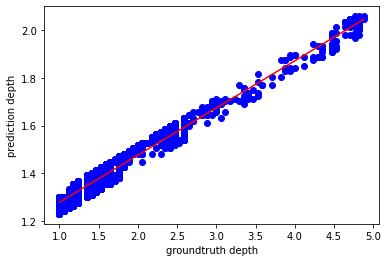

In [11]:
# Scaling Main ##
periods = 1

# Storing datapoints
total_unity = []
total_pred = []

## Getting number of images - Main file
path, dirs, files = next(os.walk(os.path.join(arg_data_root_dir, input_path)))
file_count = len(files)
total_sections = int(file_count/2) - 120 # to account for left and right
if (120*periods < total_sections):
    total_sections = 120*periods
    
print(total_sections)

for section in range(math.floor((total_sections/5))):

    # Create JSON file
    json_path = test_data_dict_dir
    start_image = section * 5 + 120
    print("Creating JSON file starting with image %i..." % (start_image))
    write_json(json_path, start_image, input_path + input_name, depth_path + depth_name, 1)


    # Building Model
    print("\nBuilding model...")
    model, test_loader, metrics, device = build_model(arg_backbone, arg_refinenet, arg_trained_models_dir, arg_fl, test_data_dict_dir, arg_data_root_dir, use_gan, use_cuda)

    # Testing images
    print("\nTesting images...")
    image, output = do_test(model, metrics, test_loader, device)

    # Finding scaling
    print("\nFinding scaling...")
    for i in range(5):
        unity_flat, pred_flat,_,_ = find_scaling_points(output, depth_path+depth_name, image, i, 1, "/home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/", arg_data_root_dir, section)
        total_unity = np.hstack((total_unity, unity_flat))
        total_pred = np.hstack((total_pred, pred_flat))
        
## Getting number of images - Compliment file
path, dirs, files = next(os.walk(os.path.join(arg_data_root_dir, comp_input_path)))
file_count = len(files)
total_sections = int(file_count/2) - 120 # to account for left and right
if (120*periods < total_sections):
    total_sections = 120*periods

for section in range(math.floor((total_sections/5))):

    # Create JSON file
    json_path = test_data_dict_dir
    start_image = section * 5 + 120
    print("Creating JSON file starting with image %i..." % (start_image))
    write_json(json_path, start_image, comp_input_path + comp_input_name, comp_depth_path + comp_depth_name, 1)


    # Building Model
    print("\nBuilding model...")
    model, test_loader, metrics, device = build_model(arg_backbone, arg_refinenet, arg_trained_models_dir, arg_fl, test_data_dict_dir, arg_data_root_dir, use_gan, use_cuda)

    # Testing images
    print("\nTesting images...")
    image, output = do_test(model, metrics, test_loader, device)

    # Finding scaling
    print("\nFinding scaling...")
    for i in range(5):
        unity_flat, pred_flat,_,_ = find_scaling_points(output, comp_depth_path+comp_depth_name, image, i, 1, "/home/shubham/HumanCamera/ST-CLSTM/Outputs/Scaling/", arg_data_root_dir, section)
        total_unity = np.hstack((total_unity, unity_flat))
        total_pred = np.hstack((total_pred, pred_flat))
    
## Finding scaling

print("\nTotal points used to find the scaling" + str(total_unity.shape))

# Correlation metrics - sanity check
pearson_coeff, p = scipy.stats.pearsonr(unity_flat, pred_flat)
print("Pearson Coefficient: %.5f, its p-value: %f" % (pearson_coeff, p))
spearman_coeff, p = scipy.stats.spearmanr(unity_flat, pred_flat)
print("Spearman Coefficient: %.5f, its p-value: %f" % (spearman_coeff, p))

# Plot pred_depth (y) vs. unity_depth (x)
plt.plot(unity_flat, pred_flat, 'bo')
plt.xlabel("groundtruth depth")
plt.ylabel("prediction depth")

# Linear Regression 
unity_reshape = np.reshape(unity_flat, (-1, 1))
pred_reshape = np.reshape(pred_flat, (-1, 1))
regressor = LinearRegression()
regressor.fit(unity_reshape, pred_reshape)

interval = np.linspace(np.amin(unity_reshape), np.amax(unity_reshape))
plt.plot(interval, float(regressor.coef_) * interval + float(regressor.intercept_), 'r')

print("The relationship is: prediction_depth = %f * gt_depth + %f" %(float(regressor.coef_), float(regressor.intercept_)))

wave = np.sin(2*np.pi*500*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)

# for each video, redo the scaling

# MSE, MAE for evaluation

# PSNR (optional)


In [26]:
# Oscillation Evaluation ##
periods = 1
regressor.coef_ = 0.195768
regressor.intercept_ = 1.103987


# Getting number of images
path, dirs, files = next(os.walk(os.path.join(arg_data_root_dir, input_path)))
file_count = len(files)
total_sections = int(file_count) - 120# to account for left and right
if (120*periods*subsample < total_sections):
    total_sections = 120*periods*subsample
    
#total_sections = 5
        
print(total_sections)

total_mae = []
total_mse = []

print(math.floor((total_sections/(5*subsample))))

for section in range(math.floor((total_sections/(5*subsample)))):
    
    # Create JSON file
    json_path = test_data_dict_dir
    start_image = section * (subsample * 5) + 120 # +120 is to offset first period, which is a throw away period
    print(start_image)
    #print("Creating JSON file starting with image %i..." % (start_image))
    write_json(json_path, start_image, input_path + input_name, depth_path + depth_name, subsample)


    # Building Model
    #print("\nBuilding model...")
    model, test_loader, metrics, device = build_model(arg_backbone, arg_refinenet, arg_trained_models_dir, arg_fl, test_data_dict_dir, arg_data_root_dir, use_gan, use_cuda)

    # Testing images
    #print("\nTesting images...")
    image, output = do_test(model, metrics, test_loader, device)

    # Finding scaling
    #print("\nFinding scaling...")
    for i in range(5):
        _,_,unity_depth, pred_depth = find_scaling_points(output, depth_path+depth_name, image, i, subsample, output_folder, arg_data_root_dir, section)

        # Convert pred_depth to unity_depth using scaling found 
        pred_scaled = (pred_depth - float(regressor.intercept_)) / float(regressor.coef_)

        # Mask pixels that further than 12 units away
#         mask = np.where(unity_depth.flatten() >= end_depth)
#         unity_depth_masked = np.delete(unity_depth.flatten(), mask)
#         pred_scaled_masked = np.delete(pred_scaled.flatten(), mask)
        
        # Mask based on color channel
        bool_mask = color_mask(image[:, :, i])
        bool_mask = bool_mask.flatten()
        
        unity_depth_masked = unity_depth.flatten()[bool_mask]
        pred_scaled_masked = pred_scaled.flatten()[bool_mask]
        
        print(np.mean(unity_depth_masked))
        print(np.mean(pred_scaled_masked))
        
        # Metrics
        mae = eval_metrics.mean_absolute_error(unity_depth_masked, pred_scaled_masked)
        mse = eval_metrics.mean_squared_error(unity_depth_masked, pred_scaled_masked)
        
        print("\nFor section %i frame %i" % (section, i))
        print("MAE: " + str(mae))
        print("MSE: " + str(mse))
                
        # Saving 
        total_mae = np.hstack((total_mae, mae.flatten()))
        total_mse = np.hstack((total_mse, mse.flatten()))

print("\nShape of total MAE and MSE")
print(total_mae.shape)
print(total_mse.shape)

## Manipulations on metrics data ##

# Reshaping to (sections, frames) - each row is a section, each column is a frame
total_mae = np.reshape(total_mae, (math.floor((total_sections/(5*subsample))), arg_fl), order='C')
total_mse = np.reshape(total_mse, (math.floor((total_sections/(5*subsample))), arg_fl), order='C')

# Finding average across frames
mean_mae = np.mean(total_mae, 0)
mean_mse = np.mean(total_mse, 0)

print("Mean MAE: " + str(mean_mae))
print("Mean MSE: " + str(mean_mse))

wave = np.sin(2*np.pi*500*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)

5281
35
120


/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_120.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame120.jpg

For section 0 frame 0
MAE: 2.883983049276413
MSE: 11.007535579918196
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_150.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame150.jpg

For section 0 frame 1
MAE: 1.1766254695116982
MSE: 2.21142579378253
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_180.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame180.jpg

For section 0 frame 2
MAE: 1.2540648892553719
MSE: 3.911400349034936
path to predicted im

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_270.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame270.jpg

For section 1 frame 0
MAE: 2.266171962146217
MSE: 6.803911486095206
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_300.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame300.jpg

For section 1 frame 1
MAE: 1.1715296353747748
MSE: 3.5092988867397517
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_330.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame330.jpg

For section 1 frame 2
MAE: 1.438214071787056
MSE: 3.9666433221494684
path to predicted i

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_420.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame420.jpg

For section 2 frame 0
MAE: 2.6898261349501076
MSE: 10.232615592832085
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_450.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame450.jpg

For section 2 frame 1
MAE: 1.5440806194769463
MSE: 4.4013002467896
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_480.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame480.jpg

For section 2 frame 2
MAE: 1.5106859296971547
MSE: 4.077597186033348
path to predicted im

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_570.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame570.jpg

For section 3 frame 0
MAE: 2.6393580083028567
MSE: 10.244184093161666
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_600.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame600.jpg

For section 3 frame 1
MAE: 1.571128415910278
MSE: 4.055041265573557
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_630.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame630.jpg

For section 3 frame 2
MAE: 1.202150162288622
MSE: 2.221471192920507
path to predicted im

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_720.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame720.jpg

For section 4 frame 0
MAE: 2.884880532521944
MSE: 11.015619202924066
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_750.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame750.jpg

For section 4 frame 1
MAE: 1.229208823367341
MSE: 2.3781907339913984
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_780.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame780.jpg

For section 4 frame 2
MAE: 1.2571980643862797
MSE: 3.9456939177975094
path to predicted 

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_870.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame870.jpg

For section 5 frame 0
MAE: 2.216780623408507
MSE: 6.653697133152571
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_900.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame900.jpg

For section 5 frame 1
MAE: 1.170914468463481
MSE: 3.490610517205949
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_930.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame930.jpg

For section 5 frame 2
MAE: 1.4189015170161017
MSE: 3.891167668576222
path to predicted ima

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1020.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1020.jpg

For section 6 frame 0
MAE: 2.6902230439241146
MSE: 10.234073648179928
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1050.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1050.jpg

For section 6 frame 1
MAE: 1.5450345605871336
MSE: 4.409827793373381
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1080.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1080.jpg

For section 6 frame 2
MAE: 1.508102843274902
MSE: 4.064053575552631
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1170.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1170.jpg

For section 7 frame 0
MAE: 2.620523844475136
MSE: 10.148309404620955
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1200.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1200.jpg

For section 7 frame 1
MAE: 1.5688859747110004
MSE: 4.047652867503886
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1230.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1230.jpg

For section 7 frame 2
MAE: 1.1408151310263557
MSE: 2.079892007830283
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1320.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1320.jpg

For section 8 frame 0
MAE: 2.8839947866482585
MSE: 11.011282092874913
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1350.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1350.jpg

For section 8 frame 1
MAE: 1.2446710116361268
MSE: 2.400842054302479
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1380.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1380.jpg

For section 8 frame 2
MAE: 1.2581913576392447
MSE: 3.9393451249121583
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1470.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1470.jpg

For section 9 frame 0
MAE: 2.2728164145762144
MSE: 6.858953569079934
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1500.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1500.jpg

For section 9 frame 1
MAE: 1.174148336245347
MSE: 3.5093821763769966
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1530.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1530.jpg

For section 9 frame 2
MAE: 1.436351833670216
MSE: 3.952789591919517
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1620.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1620.jpg

For section 10 frame 0
MAE: 2.690917486505444
MSE: 10.236763148843654
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1650.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1650.jpg

For section 10 frame 1
MAE: 1.52255212711419
MSE: 4.312454767853179
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1680.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1680.jpg

For section 10 frame 2
MAE: 1.5034375419610246
MSE: 4.043379960872624
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1770.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1770.jpg

For section 11 frame 0
MAE: 2.6133437918643696
MSE: 10.03375724594806
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1800.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1800.jpg

For section 11 frame 1
MAE: 1.5649311070903902
MSE: 4.034830364579113
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1830.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1830.jpg

For section 11 frame 2
MAE: 1.1878991331491293
MSE: 2.1864852016019674
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1920.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1920.jpg

For section 12 frame 0
MAE: 2.8845474941976574
MSE: 11.015158286437602
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1950.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1950.jpg

For section 12 frame 1
MAE: 1.1830000842133592
MSE: 2.2133307947577134
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_1980.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame1980.jpg

For section 12 frame 2
MAE: 1.2491225107958608
MSE: 3.890019563028914
path to 

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2070.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2070.jpg

For section 13 frame 0
MAE: 2.275190710687284
MSE: 6.886601320811852
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2100.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2100.jpg

For section 13 frame 1
MAE: 1.1731922625752969
MSE: 3.516727279865811
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2130.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2130.jpg

For section 13 frame 2
MAE: 1.4155714418727685
MSE: 3.868565653382466
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2220.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2220.jpg

For section 14 frame 0
MAE: 2.689466916053371
MSE: 10.228116292628412
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2250.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2250.jpg

For section 14 frame 1
MAE: 1.5683305205518954
MSE: 4.463456553271656
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2280.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2280.jpg

For section 14 frame 2
MAE: 1.5175341259803117
MSE: 4.09685875258513
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2370.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2370.jpg

For section 15 frame 0
MAE: 2.617372917236952
MSE: 10.085002243277417
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2400.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2400.jpg

For section 15 frame 1
MAE: 1.5657250773381064
MSE: 4.023521359268299
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2430.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2430.jpg

For section 15 frame 2
MAE: 1.2036264658505733
MSE: 2.20547025469768
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2520.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2520.jpg

For section 16 frame 0
MAE: 2.884508027051078
MSE: 11.0141420906183
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2550.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2550.jpg

For section 16 frame 1
MAE: 1.1974038354393337
MSE: 2.2404561072669313
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2580.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2580.jpg

For section 16 frame 2
MAE: 1.251925400757942
MSE: 3.9078524432545603
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2670.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2670.jpg

For section 17 frame 0
MAE: 2.2907400631837156
MSE: 6.8850259017824715
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2700.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2700.jpg

For section 17 frame 1
MAE: 1.174169792171018
MSE: 3.549174629213114
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2730.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2730.jpg

For section 17 frame 2
MAE: 1.4187843441907493
MSE: 3.9066386777417144
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2820.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2820.jpg

For section 18 frame 0
MAE: 2.6904823410747554
MSE: 10.23431662554034
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2850.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2850.jpg

For section 18 frame 1
MAE: 1.5475883002817297
MSE: 4.4195493520817
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2880.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2880.jpg

For section 18 frame 2
MAE: 1.5106994584537399
MSE: 4.075220049478475
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_2970.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame2970.jpg

For section 19 frame 0
MAE: 2.609866873861596
MSE: 10.089251491160509
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3000.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3000.jpg

For section 19 frame 1
MAE: 1.5645698685829743
MSE: 4.028768638181168
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3030.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3030.jpg

For section 19 frame 2
MAE: 1.2128970763439937
MSE: 2.2084024254615455
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3120.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3120.jpg

For section 20 frame 0
MAE: 2.884071488857123
MSE: 11.0111471235277
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3150.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3150.jpg

For section 20 frame 1
MAE: 1.2003910085061311
MSE: 2.257083580959225
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3180.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3180.jpg

For section 20 frame 2
MAE: 1.2484485498287083
MSE: 3.8881313824797124
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3270.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3270.jpg

For section 21 frame 0
MAE: 2.4102270573984845
MSE: 7.36995437670362
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3300.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3300.jpg

For section 21 frame 1
MAE: 1.1800296438915119
MSE: 3.539303868528523
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3330.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3330.jpg

For section 21 frame 2
MAE: 1.4268118831499568
MSE: 3.8793825042337566
path to pr

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3420.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3420.jpg

For section 22 frame 0
MAE: 2.690965343994063
MSE: 10.235810654115594
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3450.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3450.jpg

For section 22 frame 1
MAE: 1.5296439522837613
MSE: 4.310142876452354
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3480.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3480.jpg

For section 22 frame 2
MAE: 1.5056258389244124
MSE: 4.049028410112593
path to pr

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3570.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3570.jpg

For section 23 frame 0
MAE: 2.6705900452702704
MSE: 10.406327746021704
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3600.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3600.jpg

For section 23 frame 1
MAE: 1.5795929555423671
MSE: 4.087901859298737
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3630.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3630.jpg

For section 23 frame 2
MAE: 1.2136548890583858
MSE: 2.3262730868404335
path to 

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3720.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3720.jpg

For section 24 frame 0
MAE: 2.8848275560990664
MSE: 11.016388823343538
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3750.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3750.jpg

For section 24 frame 1
MAE: 1.1707717297287383
MSE: 2.206059898268252
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3780.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3780.jpg

For section 24 frame 2
MAE: 1.2522086295604185
MSE: 3.9177794172399136
path to 

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3870.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3870.jpg

For section 25 frame 0
MAE: 2.2547696417879663
MSE: 6.804025777409294
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3900.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3900.jpg

For section 25 frame 1
MAE: 1.1773125820035768
MSE: 3.536835742632757
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_3930.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame3930.jpg

For section 25 frame 2
MAE: 1.4297883883804907
MSE: 3.9328678201572207
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4020.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4020.jpg

For section 26 frame 0
MAE: 2.6905571116610587
MSE: 10.232575604815937
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4050.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4050.jpg

For section 26 frame 1
MAE: 1.5602328744678624
MSE: 4.474633798334737
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4080.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4080.jpg

For section 26 frame 2
MAE: 1.5106770990294094
MSE: 4.079894037838106
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4170.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4170.jpg

For section 27 frame 0
MAE: 2.6049031865073253
MSE: 10.055685139071507
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4200.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4200.jpg

For section 27 frame 1
MAE: 1.5678830068421228
MSE: 4.05609317448334
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4230.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4230.jpg

For section 27 frame 2
MAE: 1.191787927179578
MSE: 2.140344130101181
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4320.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4320.jpg

For section 28 frame 0
MAE: 2.8848748231024457
MSE: 11.01443628214139
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4350.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4350.jpg

For section 28 frame 1
MAE: 1.2763789909190728
MSE: 2.471398617178351
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4380.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4380.jpg

For section 28 frame 2
MAE: 1.2623936603268766
MSE: 3.9558347254311594
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4470.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4470.jpg

For section 29 frame 0
MAE: 2.294548912839692
MSE: 6.976569838800188
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4500.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4500.jpg

For section 29 frame 1
MAE: 1.1807581571647228
MSE: 3.554806053353442
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4530.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4530.jpg

For section 29 frame 2
MAE: 1.4271476843638553
MSE: 3.907073691908874
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4620.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4620.jpg

For section 30 frame 0
MAE: 2.6907536373035033
MSE: 10.23459237971409
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4650.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4650.jpg

For section 30 frame 1
MAE: 1.539527092769618
MSE: 4.365444134178308
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4680.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4680.jpg

For section 30 frame 2
MAE: 1.5082096407185013
MSE: 4.060697508543054
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4770.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4770.jpg

For section 31 frame 0
MAE: 2.6126358316541753
MSE: 10.050799035094418
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4800.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4800.jpg

For section 31 frame 1
MAE: 1.564162845978824
MSE: 4.042627217774521
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4830.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4830.jpg

For section 31 frame 2
MAE: 1.1689126989338707
MSE: 2.1407262315050546
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4920.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4920.jpg

For section 32 frame 0
MAE: 2.885547662144673
MSE: 11.020540381115644
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4950.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4950.jpg

For section 32 frame 1
MAE: 1.2438848236074542
MSE: 2.338787366374483
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_4980.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame4980.jpg

For section 32 frame 2
MAE: 1.2535739320036139
MSE: 3.9112363467957865
path to p

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5070.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5070.jpg

For section 33 frame 0
MAE: 2.2943492876660256
MSE: 6.9133072565409215
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5100.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5100.jpg

For section 33 frame 1
MAE: 1.1728205674100727
MSE: 3.508654376390948
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5130.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5130.jpg

For section 33 frame 2
MAE: 1.4432070950225675
MSE: 4.01094447311534
path to pr

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5220.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5220.jpg

For section 34 frame 0
MAE: 2.690958028040597
MSE: 10.23647246908649
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5250.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5250.jpg

For section 34 frame 1
MAE: 1.557675607286721
MSE: 4.483940073555283
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Lin_11_5x-Osc-30/pred_output_5280.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame5280.jpg

For section 34 frame 2
MAE: 1.512346536622371
MSE: 4.085974773587642
path to predi

In [ ]:
# Standard Deviation Plots

print("Total MAE:\n"+ str(total_mae))
print("Total MSE:\n" + str(total_mse))

#print(np.asarray(total_mae))
#print(total_mae[:,0])

# for i in range(5):
#     plt.hist(total_mae[:,i])
#     axes = plt.gca()
#     axes.set_ylim([0,50])
#     plt.xlabel('MAE for frame' + str(i))
#     plt.ylabel('Number of frames')
#     plt.title('MAE for Frame' + str(i))
#     plt.savefig(os.path.join(output_folder, 'MAE_hist_' + str(i) + '.jpg'))
#     plt.clf()
#     print("St. Dev. of MAE of Frame %i: %f" % (i, np.std(total_mae[:,i])))

# for i in range(5):
#     plt.hist(total_mse[:,i])
#     axes = plt.gca()
#     axes.set_ylim([0,50])
#     plt.xlabel('MSE for frame' + str(i))
#     plt.ylabel('Number of frames')
#     plt.title('MSE for Frame' + str(i))
#     plt.savefig(os.path.join(output_folder, 'MSE_hist_' + str(i) + '.jpg'))
#     plt.clf()
#     print("St. Dev. of MSE of Frame %i: %f" % (i, np.std(total_mse[:,i])))



In [27]:
# Static Evaluation ##
regressor.coef_ = 0.195768
regressor.intercept_ = 1.103987

total_mae = []
total_mse = []
total_sections = 5
periods = 3

for number in range(121,121+120*(periods)):

    # Create JSON file 
    write_dict = []
    json_path = "/home/shubham/HumanCamera/scaling-static.json"
    write_data = {        
        'rgb_index' : [],
        'depth_index' : [],
        'scene_name' : 'clip1',
        'test_index' : 4
    }
    for i in range(0,5):
        rgb_index_data = os.path.join(input_path + input_name + str(number) + '.jpg')
        write_data['rgb_index'].append(rgb_index_data)
        depth_index_data = os.path.join(depth_path + depth_name + str(number) + '.jpg')
        write_data['depth_index'].append(depth_index_data)
    write_dict.append(write_data)
    with open(json_path, 'w') as f:
        json.dump(write_dict, f)

    # Building Model
    print("\nBuilding model...")
    model, test_loader, metrics, device = build_model(arg_backbone, arg_refinenet, arg_trained_models_dir, arg_fl, json_path, arg_data_root_dir, use_gan, use_cuda)


    # Testing images
    print("\nTesting images...")
    image, output = do_test(model, metrics, test_loader, device)

    # Finding scaling
    #print("\nFinding scaling...")
    for i in range(5):
        _,_,unity_depth, pred_depth = find_scaling_points(output, depth_path+depth_name, image, i, subsample, "/home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/", arg_data_root_dir, 0, 1, number)

        # Convert pred_depth to unity_depth using scaling found 
        pred_scaled = (pred_depth - float(regressor.intercept_)) / float(regressor.coef_)

        # Mask pixels that further than 12 units away
        mask = np.where(unity_depth.flatten() >= end_depth)
        unity_depth_masked = np.delete(unity_depth.flatten(), mask)
        pred_scaled_masked = np.delete(pred_scaled.flatten(), mask)

        # Metrics
        mae = eval_metrics.mean_absolute_error(unity_depth_masked, pred_scaled_masked)
        mse = eval_metrics.mean_squared_error(unity_depth_masked, pred_scaled_masked)

        print("\nFor section %i frame %i" % (number, i))
        print("MAE: " + str(mae))
        print("MSE: " + str(mse))


        # Saving 
        total_mae = np.hstack((total_mae, mae.flatten()))
        total_mse = np.hstack((total_mse, mse.flatten()))
        
print(total_mae.shape)
print(total_mse.shape)

## Manipulations on metrics data ##

# Reshaping to (sections, frames) - each row is a section, each column is a frame
total_mae = np.reshape(total_mae, (-1, arg_fl), order='C')
total_mse = np.reshape(total_mse, (-1, arg_fl), order='C')

# Finding average across frames
mean_mae = np.mean(total_mae, 0)
mean_mse = np.mean(total_mse, 0)

print(mean_mae)
print(mean_mse)

wave = np.sin(2*np.pi*500*np.arange(10000*2)/10000)
Audio(wave, rate=10000, autoplay=True)


Building model...

Testing images...


/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_121.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame121.jpg

For section 121 frame 0
MAE: 2.915280096181122
MSE: 11.294426262233449
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_121.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame121.jpg

For section 121 frame 1
MAE: 1.563614618209488
MSE: 4.948181044494233
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_121.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame121.jpg

For section 121 frame 2
MAE: 1.540565035615501
MSE: 4.971083813301103
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_122.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame122.jpg

For section 122 frame 0
MAE: 2.681681598445149
MSE: 10.233964852844782
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_122.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame122.jpg

For section 122 frame 1
MAE: 1.4325762969223708
MSE: 4.727301828848121
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_122.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame122.jpg

For section 122 frame 2
MAE: 1.416082904849553
MSE: 4.783064835696363
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_123.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame123.jpg

For section 123 frame 0
MAE: 2.621392244093067
MSE: 9.858293920569821
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_123.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame123.jpg

For section 123 frame 1
MAE: 1.4101670704243423
MSE: 4.4990756875833355
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_123.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame123.jpg

For section 123 frame 2
MAE: 1.394342276526066
MSE: 4.5470599057967815
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_124.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame124.jpg

For section 124 frame 0
MAE: 2.6059942456038234
MSE: 9.592175563886267
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_124.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame124.jpg

For section 124 frame 1
MAE: 1.3579133322481522
MSE: 3.97669802696862
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_124.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame124.jpg

For section 124 frame 2
MAE: 1.3454269864909771
MSE: 4.00483808311467
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_125.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame125.jpg

For section 125 frame 0
MAE: 2.578359169766504
MSE: 9.561407272509724
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_125.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame125.jpg

For section 125 frame 1
MAE: 1.3706966505726814
MSE: 4.142151776192774
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_125.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame125.jpg

For section 125 frame 2
MAE: 1.353584221971433
MSE: 4.17683591199135
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_126.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame126.jpg

For section 126 frame 0
MAE: 2.3794860921186367
MSE: 8.77775094981103
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_126.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame126.jpg

For section 126 frame 1
MAE: 1.333496423459078
MSE: 3.983803775581169
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_126.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame126.jpg

For section 126 frame 2
MAE: 1.335678902567102
MSE: 4.056960585421106
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_127.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame127.jpg

For section 127 frame 0
MAE: 2.5501347364032965
MSE: 9.395807494238404
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_127.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame127.jpg

For section 127 frame 1
MAE: 1.3443851142856262
MSE: 3.884143406288829
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_127.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame127.jpg

For section 127 frame 2
MAE: 1.3322597647070213
MSE: 3.9212761947818846
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_128.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame128.jpg

For section 128 frame 0
MAE: 2.568704383025535
MSE: 9.527860826090636
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_128.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame128.jpg

For section 128 frame 1
MAE: 1.3394647958398143
MSE: 4.06894555961523
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_128.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame128.jpg

For section 128 frame 2
MAE: 1.3246295459515727
MSE: 4.1073913702062335
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_129.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame129.jpg

For section 129 frame 0
MAE: 2.3046115867116725
MSE: 8.509538023751713
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_129.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame129.jpg

For section 129 frame 1
MAE: 1.2161327717341228
MSE: 3.6913036700306177
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_129.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame129.jpg

For section 129 frame 2
MAE: 1.228752100839894
MSE: 3.770324658465571
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_130.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame130.jpg

For section 130 frame 0
MAE: 2.5890697179416207
MSE: 9.497350299622765
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_130.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame130.jpg

For section 130 frame 1
MAE: 1.2947192394196505
MSE: 4.032674181695626
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_130.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame130.jpg

For section 130 frame 2
MAE: 1.266302517519169
MSE: 4.068348591053939
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_131.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame131.jpg

For section 131 frame 0
MAE: 2.9700476853577653
MSE: 10.91959298280032
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_131.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame131.jpg

For section 131 frame 1
MAE: 1.5064951007385916
MSE: 4.1746527799348305
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_131.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame131.jpg

For section 131 frame 2
MAE: 1.4635015468081427
MSE: 4.166589378384148
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_132.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame132.jpg

For section 132 frame 0
MAE: 3.1829299215908087
MSE: 12.067471139247214
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_132.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame132.jpg

For section 132 frame 1
MAE: 1.655600114744236
MSE: 4.554404354947379
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_132.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame132.jpg

For section 132 frame 2
MAE: 1.6081337764602883
MSE: 4.496960180358129
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_133.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame133.jpg

For section 133 frame 0
MAE: 3.2497898470173996
MSE: 12.671258035433207
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_133.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame133.jpg

For section 133 frame 1
MAE: 1.76062135195893
MSE: 5.0887371517759865
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_133.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame133.jpg

For section 133 frame 2
MAE: 1.7115004350209382
MSE: 4.989278520945676
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_134.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame134.jpg

For section 134 frame 0
MAE: 3.247369736952666
MSE: 12.942160922074414
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_134.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame134.jpg

For section 134 frame 1
MAE: 1.8131297597708895
MSE: 5.761510187362611
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_134.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame134.jpg

For section 134 frame 2
MAE: 1.7576773868012825
MSE: 5.6332289151503705
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_135.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame135.jpg

For section 135 frame 0
MAE: 3.199373853603623
MSE: 12.347371313531262
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_135.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame135.jpg

For section 135 frame 1
MAE: 1.7680547775347042
MSE: 5.104273820069287
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_135.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame135.jpg

For section 135 frame 2
MAE: 1.7139564339018598
MSE: 4.984094156131374
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_136.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame136.jpg

For section 136 frame 0
MAE: 2.9382656992490555
MSE: 11.008866184929811
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_136.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame136.jpg

For section 136 frame 1
MAE: 1.600892566877766
MSE: 4.618524962946168
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_136.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame136.jpg

For section 136 frame 2
MAE: 1.5470091119634406
MSE: 4.5422369877240945
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_137.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame137.jpg

For section 137 frame 0
MAE: 2.878136974133104
MSE: 10.321942036400037
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_137.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame137.jpg

For section 137 frame 1
MAE: 1.4969519568225684
MSE: 3.8690745876726456
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_137.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame137.jpg

For section 137 frame 2
MAE: 1.4441010763943376
MSE: 3.8091451549363704
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_138.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame138.jpg

For section 138 frame 0
MAE: 2.7604924713196075
MSE: 10.254904416341892
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_138.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame138.jpg

For section 138 frame 1
MAE: 1.4805709768348416
MSE: 4.245989824787046
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_138.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame138.jpg

For section 138 frame 2
MAE: 1.4516698849219392
MSE: 4.231219726432632
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_139.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame139.jpg

For section 139 frame 0
MAE: 2.465420429064101
MSE: 8.689658601601309
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_139.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame139.jpg

For section 139 frame 1
MAE: 1.3154467798958325
MSE: 3.437591887248125
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_139.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame139.jpg

For section 139 frame 2
MAE: 1.2979766493244649
MSE: 3.434961412554109
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_140.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame140.jpg

For section 140 frame 0
MAE: 2.526632305244635
MSE: 9.00218472258824
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_140.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame140.jpg

For section 140 frame 1
MAE: 1.340722945718044
MSE: 3.62086685006304
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_140.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame140.jpg

For section 140 frame 2
MAE: 1.3171066797999147
MSE: 3.635499256033855
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_141.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame141.jpg

For section 141 frame 0
MAE: 2.6306317487814908
MSE: 9.14256578195793
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_141.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame141.jpg

For section 141 frame 1
MAE: 1.337774705848404
MSE: 3.3599004370416807
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_141.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame141.jpg

For section 141 frame 2
MAE: 1.2988652289628
MSE: 3.3668163763623573
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_142.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame142.jpg

For section 142 frame 0
MAE: 2.50048896984883
MSE: 8.725649423563784
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_142.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame142.jpg

For section 142 frame 1
MAE: 1.31208643373057
MSE: 3.335841731504086
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_142.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame142.jpg

For section 142 frame 2
MAE: 1.2880844060261003
MSE: 3.364486322095288
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_143.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame143.jpg

For section 143 frame 0
MAE: 2.3776357973594022
MSE: 8.064284115875108
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_143.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame143.jpg

For section 143 frame 1
MAE: 1.1962984123469438
MSE: 3.2458110292802953
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_143.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame143.jpg

For section 143 frame 2
MAE: 1.1782965408950483
MSE: 3.316609017396249
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_144.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame144.jpg

For section 144 frame 0
MAE: 2.3320698528293957
MSE: 7.679508809944374
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_144.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame144.jpg

For section 144 frame 1
MAE: 1.165955095284303
MSE: 3.0431986698067846
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_144.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame144.jpg

For section 144 frame 2
MAE: 1.1415587925740134
MSE: 3.087629008314858
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_145.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame145.jpg

For section 145 frame 0
MAE: 2.266237956736701
MSE: 7.258637249000953
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_145.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame145.jpg

For section 145 frame 1
MAE: 1.1222122080816548
MSE: 2.713925575354484
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_145.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame145.jpg

For section 145 frame 2
MAE: 1.099757988305196
MSE: 2.7184622313656766
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_146.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame146.jpg

For section 146 frame 0
MAE: 2.154147568601449
MSE: 6.886901758198787
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_146.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame146.jpg

For section 146 frame 1
MAE: 1.0821109145683636
MSE: 2.611622136757454
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_146.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame146.jpg

For section 146 frame 2
MAE: 1.0684574013579762
MSE: 2.6345101435171223
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_147.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame147.jpg

For section 147 frame 0
MAE: 2.4677594158676053
MSE: 7.773347905907283
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_147.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame147.jpg

For section 147 frame 1
MAE: 1.1990006257558947
MSE: 2.695665119434979
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_147.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame147.jpg

For section 147 frame 2
MAE: 1.1603078942355636
MSE: 2.692929533226923
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_148.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame148.jpg

For section 148 frame 0
MAE: 2.281634330483892
MSE: 6.942126640799661
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_148.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame148.jpg

For section 148 frame 1
MAE: 1.0730554500619653
MSE: 2.291122773971148
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_148.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame148.jpg

For section 148 frame 2
MAE: 1.0433966133066603
MSE: 2.303542814272457
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_149.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame149.jpg

For section 149 frame 0
MAE: 2.2291031017347422
MSE: 6.800333023145593
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_149.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame149.jpg

For section 149 frame 1
MAE: 1.0461108471616964
MSE: 2.3154256989424082
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_149.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame149.jpg

For section 149 frame 2
MAE: 1.0218124010378304
MSE: 2.3319089352217297
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_150.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame150.jpg

For section 150 frame 0
MAE: 2.1771846720221166
MSE: 6.5091190642622205
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_150.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame150.jpg

For section 150 frame 1
MAE: 0.995882858523795
MSE: 2.0507175226626244
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_150.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame150.jpg

For section 150 frame 2
MAE: 0.9739198160874999
MSE: 2.0601435375918737
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_151.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame151.jpg

For section 151 frame 0
MAE: 2.227534048519631
MSE: 6.994538365912881
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_151.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame151.jpg

For section 151 frame 1
MAE: 1.0782254955075068
MSE: 2.4531151310539903
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_151.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame151.jpg

For section 151 frame 2
MAE: 1.0582426138367977
MSE: 2.474739655317885
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_152.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame152.jpg

For section 152 frame 0
MAE: 2.1329678313824414
MSE: 6.817968493845071
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_152.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame152.jpg

For section 152 frame 1
MAE: 1.0838216544820714
MSE: 2.5593397542918352
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_152.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame152.jpg

For section 152 frame 2
MAE: 1.0707473163788974
MSE: 2.579907423854683
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_153.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame153.jpg

For section 153 frame 0
MAE: 2.3558096710691108
MSE: 7.59965491641988
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_153.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame153.jpg

For section 153 frame 1
MAE: 1.1597676393315333
MSE: 2.7140793463229476
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_153.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame153.jpg

For section 153 frame 2
MAE: 1.1315605424212485
MSE: 2.7026691647393304
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_154.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame154.jpg

For section 154 frame 0
MAE: 2.3993528990736093
MSE: 7.939986538343227
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_154.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame154.jpg

For section 154 frame 1
MAE: 1.199570939179145
MSE: 3.1504626062844894
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_154.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame154.jpg

For section 154 frame 2
MAE: 1.1697641971791986
MSE: 3.187950758693361
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_155.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame155.jpg

For section 155 frame 0
MAE: 2.398953873754918
MSE: 8.048336075383915
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_155.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame155.jpg

For section 155 frame 1
MAE: 1.1996371347805228
MSE: 3.20439364823307
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_155.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame155.jpg

For section 155 frame 2
MAE: 1.1743327370110612
MSE: 3.262138834571182
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_156.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame156.jpg

For section 156 frame 0
MAE: 2.374483005055701
MSE: 8.066039351743152
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_156.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame156.jpg

For section 156 frame 1
MAE: 1.2171544285141433
MSE: 3.0499763414235974
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_156.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame156.jpg

For section 156 frame 2
MAE: 1.1969561168487255
MSE: 3.0893263559256594
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_157.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame157.jpg

For section 157 frame 0
MAE: 2.6182376861424412
MSE: 9.311615954729712
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_157.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame157.jpg

For section 157 frame 1
MAE: 1.3809129334598063
MSE: 3.678466940546417
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_157.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame157.jpg

For section 157 frame 2
MAE: 1.3496388632016203
MSE: 3.688093433280173
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_158.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame158.jpg

For section 158 frame 0
MAE: 2.5012249068099996
MSE: 8.789761607081832
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_158.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame158.jpg

For section 158 frame 1
MAE: 1.2914486828498992
MSE: 3.514480634719075
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_158.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame158.jpg

For section 158 frame 2
MAE: 1.2690423184432016
MSE: 3.529212352108286
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_159.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame159.jpg

For section 159 frame 0
MAE: 2.5570890539307745
MSE: 9.177943295964251
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_159.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame159.jpg

For section 159 frame 1
MAE: 1.3737543998632726
MSE: 3.693386180442404
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_159.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame159.jpg

For section 159 frame 2
MAE: 1.3515150686460538
MSE: 3.6797345302787927
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_160.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame160.jpg

For section 160 frame 0
MAE: 2.7452919807369867
MSE: 10.38705870835614
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_160.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame160.jpg

For section 160 frame 1
MAE: 1.4978482236483643
MSE: 4.643028346293502
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_160.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame160.jpg

For section 160 frame 2
MAE: 1.4691996993318504
MSE: 4.633630361864353
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_161.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame161.jpg

For section 161 frame 0
MAE: 2.714692965571659
MSE: 9.820338102633126
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_161.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame161.jpg

For section 161 frame 1
MAE: 1.4235446406223617
MSE: 3.9526653723144864
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_161.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame161.jpg

For section 161 frame 2
MAE: 1.390817802922534
MSE: 3.921165572665137
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_162.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame162.jpg

For section 162 frame 0
MAE: 2.8010540194376876
MSE: 10.43696583856386
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_162.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame162.jpg

For section 162 frame 1
MAE: 1.5106999921591084
MSE: 4.505797926901169
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_162.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame162.jpg

For section 162 frame 2
MAE: 1.4705116727907674
MSE: 4.453398233791385
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_163.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame163.jpg

For section 163 frame 0
MAE: 3.150486039464592
MSE: 12.097861079412679
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_163.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame163.jpg

For section 163 frame 1
MAE: 1.7359284302620368
MSE: 5.155199367844767
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_163.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame163.jpg

For section 163 frame 2
MAE: 1.678212120176413
MSE: 5.038604998516242
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_164.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame164.jpg

For section 164 frame 0
MAE: 3.2165498861617805
MSE: 12.692155256190553
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_164.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame164.jpg

For section 164 frame 1
MAE: 1.785091766878204
MSE: 5.69023928261701
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_164.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame164.jpg

For section 164 frame 2
MAE: 1.7290816105188014
MSE: 5.5658676506288165
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_165.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame165.jpg

For section 165 frame 0
MAE: 3.2666297361109637
MSE: 12.775588678534646
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_165.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame165.jpg

For section 165 frame 1
MAE: 1.7466456076147725
MSE: 5.161149214714569
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_165.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame165.jpg

For section 165 frame 2
MAE: 1.6931483279244521
MSE: 5.038188905711001
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_166.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame166.jpg

For section 166 frame 0
MAE: 2.9869494619655126
MSE: 10.877898054423842
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_166.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame166.jpg

For section 166 frame 1
MAE: 1.4939861279448854
MSE: 4.083639657619698
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_166.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame166.jpg

For section 166 frame 2
MAE: 1.442870091111474
MSE: 4.030073825648902
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_167.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame167.jpg

For section 167 frame 0
MAE: 2.978030510453695
MSE: 10.767376556586978
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_167.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame167.jpg

For section 167 frame 1
MAE: 1.467123669410386
MSE: 3.8586365639821714
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_167.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame167.jpg

For section 167 frame 2
MAE: 1.4227404085215523
MSE: 3.8386032752999952
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_168.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame168.jpg

For section 168 frame 0
MAE: 2.911343499024661
MSE: 10.608529824765824
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_168.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame168.jpg

For section 168 frame 1
MAE: 1.4361890312800334
MSE: 4.142225223174971
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_168.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame168.jpg

For section 168 frame 2
MAE: 1.3957290912027276
MSE: 4.142985534513414
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_169.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame169.jpg

For section 169 frame 0
MAE: 2.5313029071431026
MSE: 8.959665807411662
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_169.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame169.jpg

For section 169 frame 1
MAE: 1.1998967047475824
MSE: 3.7454463402959925
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_169.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame169.jpg

For section 169 frame 2
MAE: 1.1770190996182268
MSE: 3.797639302736751
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_170.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame170.jpg

For section 170 frame 0
MAE: 2.7288378155943036
MSE: 9.869892275356255
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_170.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame170.jpg

For section 170 frame 1
MAE: 1.3298881385482537
MSE: 3.9368783516095145
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_170.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame170.jpg

For section 170 frame 2
MAE: 1.2950557723568887
MSE: 3.9580540582914945
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_171.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame171.jpg

For section 171 frame 0
MAE: 2.7523618022150242
MSE: 9.917908837854593
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_171.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame171.jpg

For section 171 frame 1
MAE: 1.3665652705021365
MSE: 4.002513721296806
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_171.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame171.jpg

For section 171 frame 2
MAE: 1.3369063843059577
MSE: 4.02484517230419
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_172.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame172.jpg

For section 172 frame 0
MAE: 2.5871363800323026
MSE: 9.345643475356924
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_172.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame172.jpg

For section 172 frame 1
MAE: 1.2873577639218825
MSE: 3.984776028450398
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_172.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame172.jpg

For section 172 frame 2
MAE: 1.2677953663242991
MSE: 4.018958751596278
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_173.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame173.jpg

For section 173 frame 0
MAE: 2.5158067303281277
MSE: 9.095663828006835
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_173.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame173.jpg

For section 173 frame 1
MAE: 1.2848257892326171
MSE: 3.8835806640358967
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_173.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame173.jpg

For section 173 frame 2
MAE: 1.2674181963589821
MSE: 3.9179153484210003
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_174.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame174.jpg

For section 174 frame 0
MAE: 2.5042755703371142
MSE: 9.111342489541578
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_174.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame174.jpg

For section 174 frame 1
MAE: 1.3249793174093683
MSE: 3.7285590073796735
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_174.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame174.jpg

For section 174 frame 2
MAE: 1.3170944089791685
MSE: 3.7523830302143746
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_175.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame175.jpg

For section 175 frame 0
MAE: 2.648547231560352
MSE: 9.909875564296058
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_175.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame175.jpg

For section 175 frame 1
MAE: 1.4045808929924446
MSE: 4.543643284879145
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_175.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame175.jpg

For section 175 frame 2
MAE: 1.3881473412539487
MSE: 4.596350978138729
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_176.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame176.jpg

For section 176 frame 0
MAE: 2.7346566010619693
MSE: 10.407089716435978
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_176.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame176.jpg

For section 176 frame 1
MAE: 1.4433708337947253
MSE: 4.7467910817370145
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_176.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame176.jpg

For section 176 frame 2
MAE: 1.4210100009072641
MSE: 4.792784960709103
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_177.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame177.jpg

For section 177 frame 0
MAE: 2.8544374032045674
MSE: 10.963019178794625
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_177.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame177.jpg

For section 177 frame 1
MAE: 1.5230269354156134
MSE: 4.872296854111614
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_177.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame177.jpg

For section 177 frame 2
MAE: 1.4993735274816915
MSE: 4.891091595771016
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_178.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame178.jpg

For section 178 frame 0
MAE: 2.9014945148988422
MSE: 11.006354284231874
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_178.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame178.jpg

For section 178 frame 1
MAE: 1.551114941465143
MSE: 4.978385419092832
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_178.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame178.jpg

For section 178 frame 2
MAE: 1.5275869935023096
MSE: 4.979664529353255
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_179.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame179.jpg

For section 179 frame 0
MAE: 2.6856395729960507
MSE: 10.170272049297523
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_179.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame179.jpg

For section 179 frame 1
MAE: 1.4239442560883402
MSE: 4.75839034534159
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_179.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame179.jpg

For section 179 frame 2
MAE: 1.414502819669953
MSE: 4.829181913481095
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_180.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame180.jpg

For section 180 frame 0
MAE: 2.6951216758326386
MSE: 10.252696100677857
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_180.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame180.jpg

For section 180 frame 1
MAE: 1.4087756842041004
MSE: 4.706816672225647
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_180.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame180.jpg

For section 180 frame 2
MAE: 1.3991748813528717
MSE: 4.788538620106247
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_181.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame181.jpg

For section 181 frame 0
MAE: 2.7535291922503142
MSE: 10.413257354187872
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_181.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame181.jpg

For section 181 frame 1
MAE: 1.431317283734422
MSE: 4.604365285670501
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_181.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame181.jpg

For section 181 frame 2
MAE: 1.4175628529472528
MSE: 4.643138671400216
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_182.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame182.jpg

For section 182 frame 0
MAE: 2.8459764602177833
MSE: 10.865475390034812
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_182.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame182.jpg

For section 182 frame 1
MAE: 1.5338092344103005
MSE: 4.922329879085377
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_182.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame182.jpg

For section 182 frame 2
MAE: 1.5104922126457587
MSE: 4.92179586271548
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_183.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame183.jpg

For section 183 frame 0
MAE: 2.810084023760043
MSE: 10.93751320582138
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_183.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame183.jpg

For section 183 frame 1
MAE: 1.6205222224225317
MSE: 5.15731413363097
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_183.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame183.jpg

For section 183 frame 2
MAE: 1.6039274266874288
MSE: 5.176830440727622
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_184.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame184.jpg

For section 184 frame 0
MAE: 2.8070484741620665
MSE: 10.951600103741
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_184.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame184.jpg

For section 184 frame 1
MAE: 1.5584432112137623
MSE: 4.890336046004052
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_184.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame184.jpg

For section 184 frame 2
MAE: 1.5492194497410787
MSE: 4.938551759201379
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_185.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame185.jpg

For section 185 frame 0
MAE: 2.7473854171032017
MSE: 10.745129027217862
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_185.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame185.jpg

For section 185 frame 1
MAE: 1.470975713842504
MSE: 4.855613521166384
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_185.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame185.jpg

For section 185 frame 2
MAE: 1.4627255888928798
MSE: 4.925961040316279
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_186.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame186.jpg

For section 186 frame 0
MAE: 2.7431869160860356
MSE: 10.647409131016136
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_186.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame186.jpg

For section 186 frame 1
MAE: 1.467958496747128
MSE: 4.845800016903905
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_186.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame186.jpg

For section 186 frame 2
MAE: 1.4596724248084627
MSE: 4.91153386902005
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_187.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame187.jpg

For section 187 frame 0
MAE: 2.764903103220821
MSE: 10.600931918970593
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_187.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame187.jpg

For section 187 frame 1
MAE: 1.4077081905903013
MSE: 4.542349975853261
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_187.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame187.jpg

For section 187 frame 2
MAE: 1.4001873381454986
MSE: 4.611270026445635
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_188.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame188.jpg

For section 188 frame 0
MAE: 2.9517776095993558
MSE: 11.495487279925124
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_188.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame188.jpg

For section 188 frame 1
MAE: 1.5839907697395756
MSE: 5.217555716824455
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_188.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame188.jpg

For section 188 frame 2
MAE: 1.5788523279934585
MSE: 5.281314845696461
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_189.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame189.jpg

For section 189 frame 0
MAE: 2.9230932165761843
MSE: 11.271894470709642
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_189.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame189.jpg

For section 189 frame 1
MAE: 1.6312184859709042
MSE: 5.118202487599039
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_189.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame189.jpg

For section 189 frame 2
MAE: 1.6218336260105803
MSE: 5.157258817629596
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_190.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame190.jpg

For section 190 frame 0
MAE: 2.8724067493210743
MSE: 11.15280553058248
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_190.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame190.jpg

For section 190 frame 1
MAE: 1.6689665876152784
MSE: 5.262957645723701
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_190.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame190.jpg

For section 190 frame 2
MAE: 1.6626155333440777
MSE: 5.315131106020617
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_191.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame191.jpg

For section 191 frame 0
MAE: 2.7343635522035115
MSE: 10.714573407983348
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_191.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame191.jpg

For section 191 frame 1
MAE: 1.6712707505903597
MSE: 5.288912914623305
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_191.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame191.jpg

For section 191 frame 2
MAE: 1.6681688153079561
MSE: 5.3707195098743945
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_192.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame192.jpg

For section 192 frame 0
MAE: 2.8181405352227498
MSE: 11.321778231562087
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_192.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame192.jpg

For section 192 frame 1
MAE: 1.8469897032629292
MSE: 5.921142244792125
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_192.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame192.jpg

For section 192 frame 2
MAE: 1.8494104151420063
MSE: 5.997553540759488
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_193.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame193.jpg

For section 193 frame 0
MAE: 2.8433548518891776
MSE: 11.469501308528695
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_193.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame193.jpg

For section 193 frame 1
MAE: 1.8593168633178796
MSE: 6.081736436537994
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_193.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame193.jpg

For section 193 frame 2
MAE: 1.8621493502156976
MSE: 6.13790798099937
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_194.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame194.jpg

For section 194 frame 0
MAE: 2.811509678168564
MSE: 11.361674836542997
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_194.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame194.jpg

For section 194 frame 1
MAE: 1.8439691721507878
MSE: 6.192083138810256
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_194.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame194.jpg

For section 194 frame 2
MAE: 1.8531090168411124
MSE: 6.26109856308179
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_195.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame195.jpg

For section 195 frame 0
MAE: 2.7819847176302135
MSE: 10.872031157439245
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_195.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame195.jpg

For section 195 frame 1
MAE: 1.8054642796393383
MSE: 5.641736845525643
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_195.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame195.jpg

For section 195 frame 2
MAE: 1.8122684955964659
MSE: 5.691931903913856
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_196.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame196.jpg

For section 196 frame 0
MAE: 2.7302616353770572
MSE: 10.413972401228692
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_196.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame196.jpg

For section 196 frame 1
MAE: 1.7899912450235074
MSE: 5.391042078209469
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_196.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame196.jpg

For section 196 frame 2
MAE: 1.7974382151122963
MSE: 5.448840226422355
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_197.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame197.jpg

For section 197 frame 0
MAE: 2.7218140360334657
MSE: 10.306366819388312
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_197.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame197.jpg

For section 197 frame 1
MAE: 1.8240267518499567
MSE: 5.3988975314432155
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_197.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame197.jpg

For section 197 frame 2
MAE: 1.8297870545187096
MSE: 5.458793477696475
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_198.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame198.jpg

For section 198 frame 0
MAE: 2.643494169472663
MSE: 9.816592120177317
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_198.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame198.jpg

For section 198 frame 1
MAE: 1.7680414791373753
MSE: 5.196110563290427
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_198.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame198.jpg

For section 198 frame 2
MAE: 1.7786948624799934
MSE: 5.266415310491113
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_199.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame199.jpg

For section 199 frame 0
MAE: 2.587167651295563
MSE: 9.599397594102323
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_199.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame199.jpg

For section 199 frame 1
MAE: 1.774053790542709
MSE: 5.243680801936849
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_199.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame199.jpg

For section 199 frame 2
MAE: 1.7932287472368011
MSE: 5.3331260943384615
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_200.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame200.jpg

For section 200 frame 0
MAE: 2.6510907729407247
MSE: 10.22460777907253
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_200.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame200.jpg

For section 200 frame 1
MAE: 1.8693795119295287
MSE: 5.941896006304537
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_200.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame200.jpg

For section 200 frame 2
MAE: 1.8880108713110113
MSE: 6.033094475175748
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_201.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame201.jpg

For section 201 frame 0
MAE: 2.721991862378683
MSE: 10.590094491914632
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_201.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame201.jpg

For section 201 frame 1
MAE: 1.8734734016705976
MSE: 5.965212779813884
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_201.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame201.jpg

For section 201 frame 2
MAE: 1.8876578251915364
MSE: 6.047970701597784
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_202.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame202.jpg

For section 202 frame 0
MAE: 2.669708379368293
MSE: 10.418103855847804
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_202.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame202.jpg

For section 202 frame 1
MAE: 1.8696615129944738
MSE: 5.994152655045413
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_202.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame202.jpg

For section 202 frame 2
MAE: 1.8913250322706658
MSE: 6.108650590025726
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_203.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame203.jpg

For section 203 frame 0
MAE: 2.73035868413295
MSE: 10.851866341509025
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_203.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame203.jpg

For section 203 frame 1
MAE: 1.9549796904157493
MSE: 6.403839382005165
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_203.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame203.jpg

For section 203 frame 2
MAE: 1.975078824586204
MSE: 6.526240811397079
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_204.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame204.jpg

For section 204 frame 0
MAE: 2.698536095576241
MSE: 10.763058208644853
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_204.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame204.jpg

For section 204 frame 1
MAE: 1.9360503653589356
MSE: 6.31446617940795
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_204.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame204.jpg

For section 204 frame 2
MAE: 1.9564982809762337
MSE: 6.423729732638195
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_205.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame205.jpg

For section 205 frame 0
MAE: 2.686962336939755
MSE: 10.64311674610553
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_205.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame205.jpg

For section 205 frame 1
MAE: 1.9361787057478275
MSE: 6.309278359976507
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_205.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame205.jpg

For section 205 frame 2
MAE: 1.9576830430792427
MSE: 6.424847366789943
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_206.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame206.jpg

For section 206 frame 0
MAE: 2.653455114011246
MSE: 10.351052147980846
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_206.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame206.jpg

For section 206 frame 1
MAE: 1.862024654154495
MSE: 5.944937441276697
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_206.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame206.jpg

For section 206 frame 2
MAE: 1.8840389542189129
MSE: 6.065622621623351
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_207.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame207.jpg

For section 207 frame 0
MAE: 2.632614742007826
MSE: 10.161661489921133
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_207.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame207.jpg

For section 207 frame 1
MAE: 1.8639734480077055
MSE: 5.921983930845953
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_207.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame207.jpg

For section 207 frame 2
MAE: 1.8892531064441613
MSE: 6.0583458131483106
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_208.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame208.jpg

For section 208 frame 0
MAE: 2.6253080327541305
MSE: 10.06453234756018
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_208.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame208.jpg

For section 208 frame 1
MAE: 1.8694316150016521
MSE: 5.844110254374953
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_208.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame208.jpg

For section 208 frame 2
MAE: 1.8946337221811889
MSE: 5.983325371697837
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_209.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame209.jpg

For section 209 frame 0
MAE: 2.590885793712821
MSE: 9.84891812064632
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_209.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame209.jpg

For section 209 frame 1
MAE: 1.8465092515034154
MSE: 5.693309786737001
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_209.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame209.jpg

For section 209 frame 2
MAE: 1.873638332186109
MSE: 5.8363997149538305
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_210.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame210.jpg

For section 210 frame 0
MAE: 2.6128290354074126
MSE: 10.008475946385104
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_210.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame210.jpg

For section 210 frame 1
MAE: 1.863632488478157
MSE: 5.835848837904342
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_210.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame210.jpg

For section 210 frame 2
MAE: 1.8902352895292152
MSE: 5.978079634994299
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_211.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame211.jpg

For section 211 frame 0
MAE: 2.632857213364841
MSE: 10.159846131592692
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_211.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame211.jpg

For section 211 frame 1
MAE: 1.8527254888967877
MSE: 5.864707942585011
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_211.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame211.jpg

For section 211 frame 2
MAE: 1.8771143732421987
MSE: 5.995474886703676
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_212.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame212.jpg

For section 212 frame 0
MAE: 2.6341282795341874
MSE: 10.156279495368567
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_212.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame212.jpg

For section 212 frame 1
MAE: 1.8703455514648752
MSE: 5.840273188747283
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_212.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame212.jpg

For section 212 frame 2
MAE: 1.8941913903718612
MSE: 5.969593496301253
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_213.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame213.jpg

For section 213 frame 0
MAE: 2.6437923883810206
MSE: 10.2803230390451
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_213.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame213.jpg

For section 213 frame 1
MAE: 1.8653930960188427
MSE: 5.897164083643138
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_213.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame213.jpg

For section 213 frame 2
MAE: 1.8890083850678652
MSE: 6.011082723826066
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_214.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame214.jpg

For section 214 frame 0
MAE: 2.7098360377750326
MSE: 10.726796686229854
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_214.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame214.jpg

For section 214 frame 1
MAE: 1.9168495312979126
MSE: 6.1884769428954876
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_214.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame214.jpg

For section 214 frame 2
MAE: 1.9384908186196925
MSE: 6.306382602841406
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_215.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame215.jpg

For section 215 frame 0
MAE: 2.7029851086506773
MSE: 10.741496696536592
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_215.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame215.jpg

For section 215 frame 1
MAE: 1.9510562628085062
MSE: 6.292526992489801
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_215.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame215.jpg

For section 215 frame 2
MAE: 1.9735838147193039
MSE: 6.418755424354983
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_216.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame216.jpg

For section 216 frame 0
MAE: 2.6228300598551386
MSE: 10.14215161349313
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_216.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame216.jpg

For section 216 frame 1
MAE: 1.8346763289048367
MSE: 5.778206447483505
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_216.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame216.jpg

For section 216 frame 2
MAE: 1.8593938293306398
MSE: 5.900718431523156
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_217.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame217.jpg

For section 217 frame 0
MAE: 2.6687908036542436
MSE: 10.306298326525425
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_217.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame217.jpg

For section 217 frame 1
MAE: 1.8423326212561957
MSE: 5.738154614201744
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_217.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame217.jpg

For section 217 frame 2
MAE: 1.859854008702453
MSE: 5.830870561911133
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_218.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame218.jpg

For section 218 frame 0
MAE: 2.6328289612479567
MSE: 10.170365118009796
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_218.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame218.jpg

For section 218 frame 1
MAE: 1.8608469323976125
MSE: 5.909502211861432
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_218.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame218.jpg

For section 218 frame 2
MAE: 1.8800578496890161
MSE: 6.003803652217433
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_219.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame219.jpg

For section 219 frame 0
MAE: 2.5684880630536338
MSE: 9.511572943447886
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_219.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame219.jpg

For section 219 frame 1
MAE: 1.7807204868013076
MSE: 5.186832916224089
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_219.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame219.jpg

For section 219 frame 2
MAE: 1.8012202938044684
MSE: 5.284724471152451
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_220.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame220.jpg

For section 220 frame 0
MAE: 2.6187057070798025
MSE: 9.747053954456655
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_220.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame220.jpg

For section 220 frame 1
MAE: 1.7692740462981753
MSE: 5.195067647043936
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_220.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame220.jpg

For section 220 frame 2
MAE: 1.781805653125688
MSE: 5.273483347682512
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_221.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame221.jpg

For section 221 frame 0
MAE: 2.6950300739868043
MSE: 10.158860678536255
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_221.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame221.jpg

For section 221 frame 1
MAE: 1.8253927349564159
MSE: 5.286730109472937
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_221.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame221.jpg

For section 221 frame 2
MAE: 1.8338727319129853
MSE: 5.3580714951110116
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_222.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame222.jpg

For section 222 frame 0
MAE: 2.7329428317349307
MSE: 10.43452836590772
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_222.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame222.jpg

For section 222 frame 1
MAE: 1.8179019766966253
MSE: 5.367733302032443
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_222.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame222.jpg

For section 222 frame 2
MAE: 1.825681182077315
MSE: 5.429013047656566
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_223.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame223.jpg

For section 223 frame 0
MAE: 2.7404481047996465
MSE: 10.58935659128197
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_223.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame223.jpg

For section 223 frame 1
MAE: 1.7956660246239375
MSE: 5.44170491342643
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_223.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame223.jpg

For section 223 frame 2
MAE: 1.8037212996206002
MSE: 5.496135813553864
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_224.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame224.jpg

For section 224 frame 0
MAE: 2.755222706087257
MSE: 10.827218498792012
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_224.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame224.jpg

For section 224 frame 1
MAE: 1.7891447737262205
MSE: 5.706522796315138
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_224.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame224.jpg

For section 224 frame 2
MAE: 1.8013498683734976
MSE: 5.785852624005445
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_225.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame225.jpg

For section 225 frame 0
MAE: 2.806452761661489
MSE: 11.304174573644614
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_225.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame225.jpg

For section 225 frame 1
MAE: 1.8423696533920542
MSE: 5.994530457782239
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_225.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame225.jpg

For section 225 frame 2
MAE: 1.8467352843046638
MSE: 6.060686096054577
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_226.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame226.jpg

For section 226 frame 0
MAE: 2.770521131272613
MSE: 11.050740935829618
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_226.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame226.jpg

For section 226 frame 1
MAE: 1.8211605649350164
MSE: 5.803984800946661
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_226.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame226.jpg

For section 226 frame 2
MAE: 1.8267620110141658
MSE: 5.896333086396184
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_227.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame227.jpg

For section 227 frame 0
MAE: 2.7220641797309546
MSE: 10.66796811400673
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_227.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame227.jpg

For section 227 frame 1
MAE: 1.689348097291815
MSE: 5.260368036638255
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_227.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame227.jpg

For section 227 frame 2
MAE: 1.6883278850476973
MSE: 5.3495069576799805
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_228.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame228.jpg

For section 228 frame 0
MAE: 2.8472403158518507
MSE: 10.94657192199403
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_228.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame228.jpg

For section 228 frame 1
MAE: 1.6442194216704296
MSE: 5.07483266438275
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_228.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame228.jpg

For section 228 frame 2
MAE: 1.638226901440542
MSE: 5.128653360718783
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_229.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame229.jpg

For section 229 frame 0
MAE: 2.8783097862334115
MSE: 11.134042153362323
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_229.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame229.jpg

For section 229 frame 1
MAE: 1.6616038690330819
MSE: 5.183854128289867
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_229.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame229.jpg

For section 229 frame 2
MAE: 1.654710784954326
MSE: 5.2295742522975734
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_230.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame230.jpg

For section 230 frame 0
MAE: 2.90872365932516
MSE: 11.234424092633596
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_230.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame230.jpg

For section 230 frame 1
MAE: 1.5716062843251033
MSE: 5.151950669924459
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_230.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame230.jpg

For section 230 frame 2
MAE: 1.5631383962826337
MSE: 5.216390507647694
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_231.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame231.jpg

For section 231 frame 0
MAE: 2.757391101162084
MSE: 10.48935001586227
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_231.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame231.jpg

For section 231 frame 1
MAE: 1.4342738150887966
MSE: 4.345105613170011
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_231.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame231.jpg

For section 231 frame 2
MAE: 1.429415086255663
MSE: 4.409877671992366
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_232.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame232.jpg

For section 232 frame 0
MAE: 2.7553272057254414
MSE: 10.686914884907877
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_232.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame232.jpg

For section 232 frame 1
MAE: 1.4720106499386794
MSE: 4.760442458675304
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_232.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame232.jpg

For section 232 frame 2
MAE: 1.4636872832669252
MSE: 4.830910825348872
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_233.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame233.jpg

For section 233 frame 0
MAE: 2.6600552348665474
MSE: 10.203161265772733
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_233.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame233.jpg

For section 233 frame 1
MAE: 1.4295985235814905
MSE: 4.5211836112191195
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_233.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame233.jpg

For section 233 frame 2
MAE: 1.4247757583596856
MSE: 4.601969959617262
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_234.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame234.jpg

For section 234 frame 0
MAE: 2.8101418767649684
MSE: 10.913987348144067
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_234.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame234.jpg

For section 234 frame 1
MAE: 1.5769000749932713
MSE: 4.830209698967178
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_234.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame234.jpg

For section 234 frame 2
MAE: 1.5676445685661187
MSE: 4.8737818484527775
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_235.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame235.jpg

For section 235 frame 0
MAE: 2.7822182178327917
MSE: 10.82173281956245
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_235.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame235.jpg

For section 235 frame 1
MAE: 1.6146186548105814
MSE: 5.089462302517453
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_235.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame235.jpg

For section 235 frame 2
MAE: 1.5984029587891184
MSE: 5.111940010427338
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_236.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame236.jpg

For section 236 frame 0
MAE: 2.8762464076625496
MSE: 11.111322317994134
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_236.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame236.jpg

For section 236 frame 1
MAE: 1.585636766561138
MSE: 4.978182337169817
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_236.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame236.jpg

For section 236 frame 2
MAE: 1.564352330773163
MSE: 4.98241681827151
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_237.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame237.jpg

For section 237 frame 0
MAE: 2.716087565518735
MSE: 10.206783538028848
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_237.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame237.jpg

For section 237 frame 1
MAE: 1.4267720861474698
MSE: 4.479914349035627
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_237.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame237.jpg

For section 237 frame 2
MAE: 1.409442767748804
MSE: 4.5269991636974245
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_238.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame238.jpg

For section 238 frame 0
MAE: 2.669025051401748
MSE: 10.162119153692206
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_238.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame238.jpg

For section 238 frame 1
MAE: 1.4154389268266427
MSE: 4.749121516754367
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_238.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame238.jpg

For section 238 frame 2
MAE: 1.4091475669897475
MSE: 4.843273624360937
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_239.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame239.jpg

For section 239 frame 0
MAE: 2.685768732084668
MSE: 10.290642453005194
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_239.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame239.jpg

For section 239 frame 1
MAE: 1.444332059680275
MSE: 4.859285870666656
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_239.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame239.jpg

For section 239 frame 2
MAE: 1.4352331422647813
MSE: 4.9305622222280725
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_240.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame240.jpg

For section 240 frame 0
MAE: 2.8837205971023288
MSE: 11.005505312760327
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_240.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame240.jpg

For section 240 frame 1
MAE: 1.5603053730586973
MSE: 4.985868906749304
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_240.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame240.jpg

For section 240 frame 2
MAE: 1.5374819481203292
MSE: 4.991124850558958
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_241.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame241.jpg

For section 241 frame 0
MAE: 2.8987293921478248
MSE: 11.190791171094864
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_241.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame241.jpg

For section 241 frame 1
MAE: 1.547636053654747
MSE: 4.906651722561165
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_241.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame241.jpg

For section 241 frame 2
MAE: 1.5241303754422646
MSE: 4.929157449264477
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_242.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame242.jpg

For section 242 frame 0
MAE: 2.7346870229848244
MSE: 10.457816795139793
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_242.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame242.jpg

For section 242 frame 1
MAE: 1.451922940953865
MSE: 4.795395403682644
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_242.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame242.jpg

For section 242 frame 2
MAE: 1.4307304291618648
MSE: 4.846587162749469
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_243.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame243.jpg

For section 243 frame 0
MAE: 2.609363034965788
MSE: 9.914150133841613
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_243.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame243.jpg

For section 243 frame 1
MAE: 1.4203287421142254
MSE: 4.575921051240737
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_243.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame243.jpg

For section 243 frame 2
MAE: 1.4046324319401968
MSE: 4.627025709569558
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_244.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame244.jpg

For section 244 frame 0
MAE: 2.5910136746297514
MSE: 9.50251851447328
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_244.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame244.jpg

For section 244 frame 1
MAE: 1.3457856735420708
MSE: 3.9073846269116235
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_244.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame244.jpg

For section 244 frame 2
MAE: 1.3328696337077441
MSE: 3.93412404025879
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_245.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame245.jpg

For section 245 frame 0
MAE: 2.49476452949184
MSE: 9.27032148924134
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_245.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame245.jpg

For section 245 frame 1
MAE: 1.3429769509377083
MSE: 4.090607061171856
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_245.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame245.jpg

For section 245 frame 2
MAE: 1.3310546960056255
MSE: 4.136615047985681
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_246.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame246.jpg

For section 246 frame 0
MAE: 2.5225125325168367
MSE: 9.277600515574093
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_246.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame246.jpg

For section 246 frame 1
MAE: 1.2885486347957362
MSE: 4.011704306273828
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_246.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame246.jpg

For section 246 frame 2
MAE: 1.2753627422517484
MSE: 4.065784239302649
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_247.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame247.jpg

For section 247 frame 0
MAE: 2.6065361152294835
MSE: 9.58233544961758
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_247.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame247.jpg

For section 247 frame 1
MAE: 1.3647964486140083
MSE: 4.0506596384182885
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_247.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame247.jpg

For section 247 frame 2
MAE: 1.3473110993699682
MSE: 4.085697667646258
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_248.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame248.jpg

For section 248 frame 0
MAE: 2.5877143843326316
MSE: 9.628795955439761
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_248.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame248.jpg

For section 248 frame 1
MAE: 1.3449885887503945
MSE: 4.092840449091722
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_248.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame248.jpg

For section 248 frame 2
MAE: 1.3312560617315703
MSE: 4.129768865115628
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_249.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame249.jpg

For section 249 frame 0
MAE: 2.5057920440027144
MSE: 9.03767615793472
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_249.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame249.jpg

For section 249 frame 1
MAE: 1.2273771390841057
MSE: 3.728658554744567
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_249.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame249.jpg

For section 249 frame 2
MAE: 1.2097266445145545
MSE: 3.783741964284843
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_250.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame250.jpg

For section 250 frame 0
MAE: 2.937356289577402
MSE: 10.83865929348057
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_250.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame250.jpg

For section 250 frame 1
MAE: 1.4696661476745816
MSE: 4.245326289864386
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_250.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame250.jpg

For section 250 frame 2
MAE: 1.4281621753506362
MSE: 4.247863639066577
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_251.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame251.jpg

For section 251 frame 0
MAE: 3.090934592574683
MSE: 11.530182969745496
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_251.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame251.jpg

For section 251 frame 1
MAE: 1.5672515146154593
MSE: 4.270216279991951
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_251.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame251.jpg

For section 251 frame 2
MAE: 1.5251101914598957
MSE: 4.248905561505344
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_252.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame252.jpg

For section 252 frame 0
MAE: 3.223588288324404
MSE: 12.259085499838235
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_252.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame252.jpg

For section 252 frame 1
MAE: 1.675362072591048
MSE: 4.517717679664238
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_252.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame252.jpg

For section 252 frame 2
MAE: 1.6291334244184201
MSE: 4.453004088163392
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_253.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame253.jpg

For section 253 frame 0
MAE: 3.330961058808183
MSE: 13.166101332417796
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_253.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame253.jpg

For section 253 frame 1
MAE: 1.815323254947426
MSE: 5.267667468059363
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_253.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame253.jpg

For section 253 frame 2
MAE: 1.7648282791299987
MSE: 5.156997642932625
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_254.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame254.jpg

For section 254 frame 0
MAE: 3.578323391396827
MSE: 14.950286462523087
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_254.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame254.jpg

For section 254 frame 1
MAE: 2.0396502463591024
MSE: 6.337506701742846
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_254.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame254.jpg

For section 254 frame 2
MAE: 1.9879729356702351
MSE: 6.169128819924388
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_255.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame255.jpg

For section 255 frame 0
MAE: 3.3708178910626416
MSE: 13.237983401888336
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_255.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame255.jpg

For section 255 frame 1
MAE: 1.874137193282471
MSE: 5.340055128430052
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_255.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame255.jpg

For section 255 frame 2
MAE: 1.8193792086037899
MSE: 5.202417594551667
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_256.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame256.jpg

For section 256 frame 0
MAE: 3.105481926679595
MSE: 11.635098141562711
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_256.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame256.jpg

For section 256 frame 1
MAE: 1.682082004940277
MSE: 4.630533301653456
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_256.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame256.jpg

For section 256 frame 2
MAE: 1.6258443042012567
MSE: 4.539254386004118
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_257.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame257.jpg

For section 257 frame 0
MAE: 2.8060272351090627
MSE: 10.048012938293665
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_257.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame257.jpg

For section 257 frame 1
MAE: 1.446048317399683
MSE: 3.8701358375921457
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_257.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame257.jpg

For section 257 frame 2
MAE: 1.39202878984144
MSE: 3.821097022314587
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_258.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame258.jpg

For section 258 frame 0
MAE: 2.8369377056963665
MSE: 10.65151896473179
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_258.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame258.jpg

For section 258 frame 1
MAE: 1.5508547705747706
MSE: 4.53150742131656
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_258.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame258.jpg

For section 258 frame 2
MAE: 1.5175321992526374
MSE: 4.4991419393364955
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_259.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame259.jpg

For section 259 frame 0
MAE: 2.68000733720367
MSE: 9.883738976886667
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_259.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame259.jpg

For section 259 frame 1
MAE: 1.4616119091957198
MSE: 4.099940022585621
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_259.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame259.jpg

For section 259 frame 2
MAE: 1.4337843898144844
MSE: 4.078792249719514
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_260.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame260.jpg

For section 260 frame 0
MAE: 2.5572202985445682
MSE: 9.23046560406044
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_260.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame260.jpg

For section 260 frame 1
MAE: 1.3878461898887915
MSE: 3.782177264371329
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_260.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame260.jpg

For section 260 frame 2
MAE: 1.3641676173105284
MSE: 3.787618724344917
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_261.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame261.jpg

For section 261 frame 0
MAE: 2.6612261681503657
MSE: 9.392530607916292
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_261.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame261.jpg

For section 261 frame 1
MAE: 1.3845571520046052
MSE: 3.604603656916792
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_261.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame261.jpg

For section 261 frame 2
MAE: 1.3389284526506984
MSE: 3.598765560621029
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_262.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame262.jpg

For section 262 frame 0
MAE: 2.4355819593563552
MSE: 8.331647338270049
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_262.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame262.jpg

For section 262 frame 1
MAE: 1.2495614045406143
MSE: 3.122806826288401
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_262.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame262.jpg

For section 262 frame 2
MAE: 1.2265087895745062
MSE: 3.1547674558661014
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_263.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame263.jpg

For section 263 frame 0
MAE: 2.3957047804747718
MSE: 8.035904022960464
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_263.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame263.jpg

For section 263 frame 1
MAE: 1.2140203890836399
MSE: 3.279885196940774
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_263.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame263.jpg

For section 263 frame 2
MAE: 1.1941106859972983
MSE: 3.359474551630027
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_264.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame264.jpg

For section 264 frame 0
MAE: 2.3392229828833995
MSE: 7.590517223433843
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_264.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame264.jpg

For section 264 frame 1
MAE: 1.166968756949016
MSE: 2.994114785984629
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_264.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame264.jpg

For section 264 frame 2
MAE: 1.1368743418411833
MSE: 3.0388289422762247
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_265.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame265.jpg

For section 265 frame 0
MAE: 2.301759355711917
MSE: 7.235695713238829
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_265.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame265.jpg

For section 265 frame 1
MAE: 1.1330416473959286
MSE: 2.729211855900139
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_265.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame265.jpg

For section 265 frame 2
MAE: 1.1007263168599957
MSE: 2.7366394904125033
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_266.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame266.jpg

For section 266 frame 0
MAE: 2.2551130256144574
MSE: 6.959591991781985
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_266.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame266.jpg

For section 266 frame 1
MAE: 1.0830598888391147
MSE: 2.481164141392749
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_266.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame266.jpg

For section 266 frame 2
MAE: 1.0558357616514547
MSE: 2.494967595032402
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_267.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame267.jpg

For section 267 frame 0
MAE: 2.38616218921941
MSE: 7.426436566035929
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_267.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame267.jpg

For section 267 frame 1
MAE: 1.1385985877344573
MSE: 2.537209968472495
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_267.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame267.jpg

For section 267 frame 2
MAE: 1.1036158264850044
MSE: 2.5518104589163473
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_268.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame268.jpg

For section 268 frame 0
MAE: 2.3776986448429906
MSE: 7.1685458032525755
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_268.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame268.jpg

For section 268 frame 1
MAE: 1.1053912512852362
MSE: 2.3057073942185946
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_268.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame268.jpg

For section 268 frame 2
MAE: 1.0660193246602419
MSE: 2.3050946853363965
path to pr

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_269.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame269.jpg

For section 269 frame 0
MAE: 2.256084224112916
MSE: 6.843016580132973
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_269.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame269.jpg

For section 269 frame 1
MAE: 1.0481474434683307
MSE: 2.274226943935794
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_269.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame269.jpg

For section 269 frame 2
MAE: 1.0180384698506717
MSE: 2.2914179353726576
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_270.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame270.jpg

For section 270 frame 0
MAE: 2.266006545955193
MSE: 6.802437307516588
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_270.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame270.jpg

For section 270 frame 1
MAE: 1.041056138123467
MSE: 2.169459633555017
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_270.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame270.jpg

For section 270 frame 2
MAE: 1.010439338480258
MSE: 2.178028542688974
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_271.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame271.jpg

For section 271 frame 0
MAE: 2.2984497695895296
MSE: 7.173082503377558
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_271.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame271.jpg

For section 271 frame 1
MAE: 1.1004820446481445
MSE: 2.4698994863128405
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_271.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame271.jpg

For section 271 frame 2
MAE: 1.0732734793023901
MSE: 2.485486739598307
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_272.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame272.jpg

For section 272 frame 0
MAE: 2.248927162599994
MSE: 7.1020938074969955
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_272.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame272.jpg

For section 272 frame 1
MAE: 1.0966003017086374
MSE: 2.543885981356889
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_272.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame272.jpg

For section 272 frame 2
MAE: 1.0754475563331676
MSE: 2.555985071225264
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_273.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame273.jpg

For section 273 frame 0
MAE: 2.383088816259399
MSE: 7.804033086422741
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_273.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame273.jpg

For section 273 frame 1
MAE: 1.1966312144618432
MSE: 2.894724899257474
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_273.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame273.jpg

For section 273 frame 2
MAE: 1.1676801515850461
MSE: 2.8938129680332003
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_274.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame274.jpg

For section 274 frame 0
MAE: 2.2997899270036197
MSE: 7.598862980758345
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_274.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame274.jpg

For section 274 frame 1
MAE: 1.1643517085054298
MSE: 3.1000551143883057
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_274.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame274.jpg

For section 274 frame 2
MAE: 1.142379409482974
MSE: 3.1494582201188304
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_275.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame275.jpg

For section 275 frame 0
MAE: 2.4636650926260173
MSE: 8.174756184503844
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_275.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame275.jpg

For section 275 frame 1
MAE: 1.221017453988989
MSE: 3.1823802194309057
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_275.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame275.jpg

For section 275 frame 2
MAE: 1.1842374505978739
MSE: 3.223909082453095
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_276.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame276.jpg

For section 276 frame 0
MAE: 2.3795594783007172
MSE: 8.102633693599314
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_276.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame276.jpg

For section 276 frame 1
MAE: 1.2209662700917328
MSE: 3.0840373243901498
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_276.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame276.jpg

For section 276 frame 2
MAE: 1.201346147232051
MSE: 3.1275032857987783
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_277.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame277.jpg

For section 277 frame 0
MAE: 2.5230899068377646
MSE: 8.892844062588733
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_277.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame277.jpg

For section 277 frame 1
MAE: 1.323960371756947
MSE: 3.503220530750506
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_277.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame277.jpg

For section 277 frame 2
MAE: 1.2994933065463117
MSE: 3.519671592506188
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_278.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame278.jpg

For section 278 frame 0
MAE: 2.435808626003978
MSE: 8.556091789843714
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_278.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame278.jpg

For section 278 frame 1
MAE: 1.2599454264319154
MSE: 3.5064358282020436
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_278.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame278.jpg

For section 278 frame 2
MAE: 1.241717194085889
MSE: 3.5315668972198306
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_279.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame279.jpg

For section 279 frame 0
MAE: 2.4844155795402574
MSE: 8.972120265447503
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_279.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame279.jpg

For section 279 frame 1
MAE: 1.3378830646310063
MSE: 3.7394337153959136
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_279.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame279.jpg

For section 279 frame 2
MAE: 1.3234125249039428
MSE: 3.7388223636154754
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_280.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame280.jpg

For section 280 frame 0
MAE: 2.704878322354292
MSE: 10.286977121313978
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_280.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame280.jpg

For section 280 frame 1
MAE: 1.4964847654286355
MSE: 4.612749451526211
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_280.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame280.jpg

For section 280 frame 2
MAE: 1.4728654130442063
MSE: 4.599411266530342
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_281.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame281.jpg

For section 281 frame 0
MAE: 2.6815779925784997
MSE: 9.791277570137945
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_281.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame281.jpg

For section 281 frame 1
MAE: 1.4177233632846382
MSE: 3.9651922534347963
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_281.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame281.jpg

For section 281 frame 2
MAE: 1.3893006465275697
MSE: 3.938594239962816
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_282.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame282.jpg

For section 282 frame 0
MAE: 2.806619572696927
MSE: 10.304564877375972
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_282.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame282.jpg

For section 282 frame 1
MAE: 1.474418930544959
MSE: 4.248145314808632
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_282.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame282.jpg

For section 282 frame 2
MAE: 1.4240629728756715
MSE: 4.18439840095745
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_283.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame283.jpg

For section 283 frame 0
MAE: 3.145233716306761
MSE: 11.956039154711446
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_283.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame283.jpg

For section 283 frame 1
MAE: 1.7031193059073149
MSE: 4.893195802580874
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_283.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame283.jpg

For section 283 frame 2
MAE: 1.6472005530332576
MSE: 4.780379603232457
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_284.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame284.jpg

For section 284 frame 0
MAE: 3.168100984850048
MSE: 12.338011808185774
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_284.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame284.jpg

For section 284 frame 1
MAE: 1.72352399730158
MSE: 5.4004627535199505
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_284.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame284.jpg

For section 284 frame 2
MAE: 1.6669117135877345
MSE: 5.277374005331592
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_285.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame285.jpg

For section 285 frame 0
MAE: 3.147953412121117
MSE: 12.089773049026087
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_285.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame285.jpg

For section 285 frame 1
MAE: 1.669178951890371
MSE: 4.9190479729642345
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_285.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame285.jpg

For section 285 frame 2
MAE: 1.6155219895061017
MSE: 4.816316045242833
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_286.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame286.jpg

For section 286 frame 0
MAE: 3.098648920085808
MSE: 11.442780566668409
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_286.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame286.jpg

For section 286 frame 1
MAE: 1.5741238107925364
MSE: 4.17162115519273
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_286.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame286.jpg

For section 286 frame 2
MAE: 1.525922416931981
MSE: 4.1097689531034005
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_287.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame287.jpg

For section 287 frame 0
MAE: 3.0446650526732264
MSE: 11.1539939979831
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_287.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame287.jpg

For section 287 frame 1
MAE: 1.5188571943675973
MSE: 4.008654792639566
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_287.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame287.jpg

For section 287 frame 2
MAE: 1.4749743546272642
MSE: 3.978758501831983
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_288.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame288.jpg

For section 288 frame 0
MAE: 2.9337375602844133
MSE: 10.72877450624971
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_288.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame288.jpg

For section 288 frame 1
MAE: 1.4502955450440258
MSE: 4.191810007743359
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_288.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame288.jpg

For section 288 frame 2
MAE: 1.4105702650660863
MSE: 4.190794846768231
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_289.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame289.jpg

For section 289 frame 0
MAE: 2.6263450948801577
MSE: 9.248214147202228
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_289.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame289.jpg

For section 289 frame 1
MAE: 1.2398461285149227
MSE: 3.772818952505257
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_289.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame289.jpg

For section 289 frame 2
MAE: 1.2135648442053815
MSE: 3.822078595407539
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_290.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame290.jpg

For section 290 frame 0
MAE: 2.7201316870158316
MSE: 9.758166329286619
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_290.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame290.jpg

For section 290 frame 1
MAE: 1.3267304858820053
MSE: 3.8739303816765935
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_290.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame290.jpg

For section 290 frame 2
MAE: 1.295414829129055
MSE: 3.8950818909936262
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_291.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame291.jpg

For section 291 frame 0
MAE: 2.8281771889727665
MSE: 10.17852117352334
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_291.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame291.jpg

For section 291 frame 1
MAE: 1.402344574121716
MSE: 3.9766068204052796
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_291.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame291.jpg

For section 291 frame 2
MAE: 1.3691323765018426
MSE: 3.990450347101426
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_292.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame292.jpg

For section 292 frame 0
MAE: 2.6820219647061263
MSE: 9.659131271401037
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_292.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame292.jpg

For section 292 frame 1
MAE: 1.3371926972188743
MSE: 4.06886760786923
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_292.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame292.jpg

For section 292 frame 2
MAE: 1.3113049058041724
MSE: 4.095522206353628
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_293.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame293.jpg

For section 293 frame 0
MAE: 2.4883441056641002
MSE: 9.064513412569433
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_293.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame293.jpg

For section 293 frame 1
MAE: 1.296644641426901
MSE: 3.928017075021444
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_293.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame293.jpg

For section 293 frame 2
MAE: 1.281437601118831
MSE: 3.9656214493894852
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_294.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame294.jpg

For section 294 frame 0
MAE: 2.542778095740765
MSE: 9.080353149084665
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_294.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame294.jpg

For section 294 frame 1
MAE: 1.2945414297274063
MSE: 3.561684630987949
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_294.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame294.jpg

For section 294 frame 2
MAE: 1.2820353891949297
MSE: 3.5853958450378687
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_295.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame295.jpg

For section 295 frame 0
MAE: 2.5706221882856313
MSE: 9.505098113932721
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_295.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame295.jpg

For section 295 frame 1
MAE: 1.3552357177464127
MSE: 4.278166726368075
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_295.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame295.jpg

For section 295 frame 2
MAE: 1.3429339304318568
MSE: 4.339106672392524
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_296.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame296.jpg

For section 296 frame 0
MAE: 2.6723255585229113
MSE: 10.124092926049624
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_296.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame296.jpg

For section 296 frame 1
MAE: 1.4218122604083736
MSE: 4.639228820057613
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_296.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame296.jpg

For section 296 frame 2
MAE: 1.4063648070400294
MSE: 4.70229226681069
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_297.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame297.jpg

For section 297 frame 0
MAE: 2.825324269214739
MSE: 10.83166057556091
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_297.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame297.jpg

For section 297 frame 1
MAE: 1.5042308281292232
MSE: 4.802846446651728
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_297.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame297.jpg

For section 297 frame 2
MAE: 1.483840355142545
MSE: 4.835760814726164
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_298.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame298.jpg

For section 298 frame 0
MAE: 2.849514322893008
MSE: 10.653478693017579
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_298.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame298.jpg

For section 298 frame 1
MAE: 1.5071671406693183
MSE: 4.718531043237926
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_298.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame298.jpg

For section 298 frame 2
MAE: 1.4860803057074756
MSE: 4.722067196863753
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_299.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame299.jpg

For section 299 frame 0
MAE: 2.616284436193667
MSE: 9.714812756896688
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_299.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame299.jpg

For section 299 frame 1
MAE: 1.3763357660484774
MSE: 4.457523282514672
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_299.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame299.jpg

For section 299 frame 2
MAE: 1.3682230757093496
MSE: 4.529662392570232
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_300.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame300.jpg

For section 300 frame 0
MAE: 2.6880436088881017
MSE: 10.224109729308587
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_300.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame300.jpg

For section 300 frame 1
MAE: 1.402963848699812
MSE: 4.698557553294595
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_300.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame300.jpg

For section 300 frame 2
MAE: 1.3939924732451943
MSE: 4.781731816286472
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_301.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame301.jpg

For section 301 frame 0
MAE: 2.7834502883469696
MSE: 10.54263113285393
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_301.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame301.jpg

For section 301 frame 1
MAE: 1.4511034235179376
MSE: 4.619163915221247
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_301.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame301.jpg

For section 301 frame 2
MAE: 1.434908056849187
MSE: 4.655946219837292
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_302.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame302.jpg

For section 302 frame 0
MAE: 2.8655966042770005
MSE: 10.949240994682114
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_302.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame302.jpg

For section 302 frame 1
MAE: 1.5472446680260343
MSE: 4.914859425334432
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_302.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame302.jpg

For section 302 frame 2
MAE: 1.5253402825125177
MSE: 4.916519574599956
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_303.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame303.jpg

For section 303 frame 0
MAE: 2.7804011403755378
MSE: 10.778315808081029
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_303.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame303.jpg

For section 303 frame 1
MAE: 1.6022890383038737
MSE: 5.136518516738081
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_303.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame303.jpg

For section 303 frame 2
MAE: 1.5847349424055448
MSE: 5.155497907318732
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_304.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame304.jpg

For section 304 frame 0
MAE: 2.802537262897586
MSE: 10.92529996379358
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_304.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame304.jpg

For section 304 frame 1
MAE: 1.5748032563531282
MSE: 4.959330437147298
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_304.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame304.jpg

For section 304 frame 2
MAE: 1.5631340637849735
MSE: 5.002196327556681
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_305.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame305.jpg

For section 305 frame 0
MAE: 2.788561185802062
MSE: 10.99558070808542
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_305.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame305.jpg

For section 305 frame 1
MAE: 1.5077228398423375
MSE: 4.986144715772946
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_305.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame305.jpg

For section 305 frame 2
MAE: 1.497694106100608
MSE: 5.055911940788308
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_306.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame306.jpg

For section 306 frame 0
MAE: 2.753119718162832
MSE: 10.693678605577652
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_306.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame306.jpg

For section 306 frame 1
MAE: 1.465324270257552
MSE: 4.836537468917363
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_306.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame306.jpg

For section 306 frame 2
MAE: 1.4576566418829837
MSE: 4.903287564293793
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_307.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame307.jpg

For section 307 frame 0
MAE: 2.7444363286769016
MSE: 10.468229703021287
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_307.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame307.jpg

For section 307 frame 1
MAE: 1.3847995535955944
MSE: 4.4465402717467395
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_307.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame307.jpg

For section 307 frame 2
MAE: 1.378633614903713
MSE: 4.516204004996376
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_308.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame308.jpg

For section 308 frame 0
MAE: 2.9454560752874923
MSE: 11.519586828403224
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_308.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame308.jpg

For section 308 frame 1
MAE: 1.5929882867255558
MSE: 5.286364091321766
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_308.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame308.jpg

For section 308 frame 2
MAE: 1.5880421413814472
MSE: 5.354735283848634
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_309.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame309.jpg

For section 309 frame 0
MAE: 2.91623076614761
MSE: 11.200103924185653
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_309.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame309.jpg

For section 309 frame 1
MAE: 1.6231464472484052
MSE: 5.033586024369731
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_309.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame309.jpg

For section 309 frame 2
MAE: 1.615374940397472
MSE: 5.0727506749610995
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_310.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame310.jpg

For section 310 frame 0
MAE: 2.894258838169948
MSE: 11.2493630955279
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_310.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame310.jpg

For section 310 frame 1
MAE: 1.6771207030412632
MSE: 5.287361520151951
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_310.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame310.jpg

For section 310 frame 2
MAE: 1.6706162833445373
MSE: 5.3357826330013705
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_311.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame311.jpg

For section 311 frame 0
MAE: 2.772042956334754
MSE: 10.952102057277019
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_311.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame311.jpg

For section 311 frame 1
MAE: 1.7070341644406355
MSE: 5.414761155558819
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_311.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame311.jpg

For section 311 frame 2
MAE: 1.7061343811696044
MSE: 5.502600049960497
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_312.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame312.jpg

For section 312 frame 0
MAE: 2.756874831959924
MSE: 10.970743519286787
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_312.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame312.jpg

For section 312 frame 1
MAE: 1.800307493038314
MSE: 5.7351662517207815
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_312.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame312.jpg

For section 312 frame 2
MAE: 1.8052377325837687
MSE: 5.819946789482803
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_313.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame313.jpg

For section 313 frame 0
MAE: 2.846352092028692
MSE: 11.561284013386471
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_313.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame313.jpg

For section 313 frame 1
MAE: 1.8481597012313686
MSE: 6.1503753456380705
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_313.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame313.jpg

For section 313 frame 2
MAE: 1.8517706893311405
MSE: 6.213451969444409
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_314.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame314.jpg

For section 314 frame 0
MAE: 2.798819759223474
MSE: 11.24081308757842
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_314.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame314.jpg

For section 314 frame 1
MAE: 1.8394877742448883
MSE: 6.059059249119677
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_314.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame314.jpg

For section 314 frame 2
MAE: 1.8498825043940799
MSE: 6.1373837285462285
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_315.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame315.jpg

For section 315 frame 0
MAE: 2.794379510208984
MSE: 10.949871962309425
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_315.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame315.jpg

For section 315 frame 1
MAE: 1.8227841989853126
MSE: 5.667357945883985
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_315.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame315.jpg

For section 315 frame 2
MAE: 1.8309769051136633
MSE: 5.722592318668752
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_316.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame316.jpg

For section 316 frame 0
MAE: 2.720760520075155
MSE: 10.332044474757168
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_316.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame316.jpg

For section 316 frame 1
MAE: 1.762727711254833
MSE: 5.2296193264154915
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_316.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame316.jpg

For section 316 frame 2
MAE: 1.7706480347479456
MSE: 5.2873098354701416
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_317.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame317.jpg

For section 317 frame 0
MAE: 2.6947335176977676
MSE: 10.201079129270944
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_317.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame317.jpg

For section 317 frame 1
MAE: 1.796928487354912
MSE: 5.253131547448851
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_317.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame317.jpg

For section 317 frame 2
MAE: 1.8033877232982152
MSE: 5.315250504847806
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_318.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame318.jpg

For section 318 frame 0
MAE: 2.6128827179724587
MSE: 9.63808290645639
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_318.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame318.jpg

For section 318 frame 1
MAE: 1.7297916883450026
MSE: 5.002980672011122
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_318.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame318.jpg

For section 318 frame 2
MAE: 1.740544960855463
MSE: 5.066530704073948
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_319.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame319.jpg

For section 319 frame 0
MAE: 2.5589373965779005
MSE: 9.423684252386368
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_319.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame319.jpg

For section 319 frame 1
MAE: 1.7473629037078575
MSE: 5.059152506198891
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_319.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame319.jpg

For section 319 frame 2
MAE: 1.768290078119792
MSE: 5.1514038808904585
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_320.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame320.jpg

For section 320 frame 0
MAE: 2.6219073584994943
MSE: 10.148414961507731
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_320.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame320.jpg

For section 320 frame 1
MAE: 1.848434178211386
MSE: 5.866563131501506
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_320.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame320.jpg

For section 320 frame 2
MAE: 1.8670728774733352
MSE: 5.958403448721581
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_321.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame321.jpg

For section 321 frame 0
MAE: 2.7188513268838443
MSE: 10.702256207780499
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_321.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame321.jpg

For section 321 frame 1
MAE: 1.902828661003911
MSE: 6.07668401014054
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_321.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame321.jpg

For section 321 frame 2
MAE: 1.9194522463535473
MSE: 6.16956647879024
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_322.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame322.jpg

For section 322 frame 0
MAE: 2.641976992022891
MSE: 10.309257160894205
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_322.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame322.jpg

For section 322 frame 1
MAE: 1.8669118561797968
MSE: 5.955430142462131
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_322.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame322.jpg

For section 322 frame 2
MAE: 1.8893480753405338
MSE: 6.070333503237028
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_323.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame323.jpg

For section 323 frame 0
MAE: 2.7209584612949635
MSE: 10.799130792375953
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_323.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame323.jpg

For section 323 frame 1
MAE: 1.9542012132118045
MSE: 6.324752403944711
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_323.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame323.jpg

For section 323 frame 2
MAE: 1.9754306744274932
MSE: 6.442847184021166
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_324.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame324.jpg

For section 324 frame 0
MAE: 2.718950814767335
MSE: 10.81653656658229
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_324.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame324.jpg

For section 324 frame 1
MAE: 1.9394170045711097
MSE: 6.271718587306228
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_324.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame324.jpg

For section 324 frame 2
MAE: 1.958736940973434
MSE: 6.379209902337694
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_325.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame325.jpg

For section 325 frame 0
MAE: 2.661739038739333
MSE: 10.453565888109887
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_325.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame325.jpg

For section 325 frame 1
MAE: 1.9032129445729242
MSE: 6.0906507303053825
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_325.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame325.jpg

For section 325 frame 2
MAE: 1.9263942221180508
MSE: 6.208609679221115
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_326.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame326.jpg

For section 326 frame 0
MAE: 2.662130223997164
MSE: 10.48145497701671
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_326.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame326.jpg

For section 326 frame 1
MAE: 1.888212679481593
MSE: 6.068295477588202
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_326.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame326.jpg

For section 326 frame 2
MAE: 1.9099712219216227
MSE: 6.1912667651902655
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_327.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame327.jpg

For section 327 frame 0
MAE: 2.6529461285500537
MSE: 10.416869140348743
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_327.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame327.jpg

For section 327 frame 1
MAE: 1.8681110188633048
MSE: 6.063704670243478
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_327.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame327.jpg

For section 327 frame 2
MAE: 1.8917394164550763
MSE: 6.19437189857474
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_328.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame328.jpg

For section 328 frame 0
MAE: 2.6482632920472113
MSE: 10.370477231217542
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_328.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame328.jpg

For section 328 frame 1
MAE: 1.8932321333056452
MSE: 6.1012685525101285
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_328.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame328.jpg

For section 328 frame 2
MAE: 1.9176199419296547
MSE: 6.242876151899694
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_329.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame329.jpg

For section 329 frame 0
MAE: 2.6438435932474325
MSE: 10.257590275190553
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_329.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame329.jpg

For section 329 frame 1
MAE: 1.8875485890044885
MSE: 5.993884720292775
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_329.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame329.jpg

For section 329 frame 2
MAE: 1.9121207870640715
MSE: 6.133947463974208
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_330.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame330.jpg

For section 330 frame 0
MAE: 2.6579495259193333
MSE: 10.372678063432156
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_330.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame330.jpg

For section 330 frame 1
MAE: 1.8720209793068558
MSE: 5.98997506624614
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_330.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame330.jpg

For section 330 frame 2
MAE: 1.8949948443802824
MSE: 6.120243751838386
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_331.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame331.jpg

For section 331 frame 0
MAE: 2.675156576984724
MSE: 10.525855281001295
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_331.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame331.jpg

For section 331 frame 1
MAE: 1.8766508405148115
MSE: 6.106490897665569
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_331.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame331.jpg

For section 331 frame 2
MAE: 1.9000531122714708
MSE: 6.236969963409237
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_332.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame332.jpg

For section 332 frame 0
MAE: 2.6752817786471166
MSE: 10.458263969124976
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_332.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame332.jpg

For section 332 frame 1
MAE: 1.8635374634283006
MSE: 5.935172723402226
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_332.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame332.jpg

For section 332 frame 2
MAE: 1.8854423863321035
MSE: 6.055260128458179
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_333.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame333.jpg

For section 333 frame 0
MAE: 2.6674321433999695
MSE: 10.503696167884108
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_333.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame333.jpg

For section 333 frame 1
MAE: 1.8951886412829841
MSE: 6.111511988341849
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_333.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame333.jpg

For section 333 frame 2
MAE: 1.9173836529907486
MSE: 6.22275147643887
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_334.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame334.jpg

For section 334 frame 0
MAE: 2.685671080192232
MSE: 10.63387739426387
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_334.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame334.jpg

For section 334 frame 1
MAE: 1.9276347218768375
MSE: 6.221653632987577
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_334.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame334.jpg

For section 334 frame 2
MAE: 1.9492304436159076
MSE: 6.340693958617252
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_335.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame335.jpg

For section 335 frame 0
MAE: 2.7140586580227826
MSE: 10.786772385627016
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_335.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame335.jpg

For section 335 frame 1
MAE: 1.9396607357637772
MSE: 6.288604574019852
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_335.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame335.jpg

For section 335 frame 2
MAE: 1.9611229599008162
MSE: 6.41343515466724
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_336.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame336.jpg

For section 336 frame 0
MAE: 2.6484856296411734
MSE: 10.32241484483463
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_336.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame336.jpg

For section 336 frame 1
MAE: 1.8536615422905238
MSE: 5.922642120868617
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_336.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame336.jpg

For section 336 frame 2
MAE: 1.8771773288084543
MSE: 6.046118292388931
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_337.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame337.jpg

For section 337 frame 0
MAE: 2.7059564908459537
MSE: 10.542682354817549
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_337.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame337.jpg

For section 337 frame 1
MAE: 1.8586653125109966
MSE: 5.858620610851101
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_337.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame337.jpg

For section 337 frame 2
MAE: 1.8758442689100756
MSE: 5.9545278233942165
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_338.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame338.jpg

For section 338 frame 0
MAE: 2.6549041116274052
MSE: 10.322147394684254
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_338.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame338.jpg

For section 338 frame 1
MAE: 1.8765616852395752
MSE: 5.995070008408402
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_338.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame338.jpg

For section 338 frame 2
MAE: 1.8947403422888822
MSE: 6.09265488497347
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_339.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame339.jpg

For section 339 frame 0
MAE: 2.57256219750305
MSE: 9.523657097240713
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_339.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame339.jpg

For section 339 frame 1
MAE: 1.7794339011300182
MSE: 5.210798493299736
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_339.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame339.jpg

For section 339 frame 2
MAE: 1.8009631329168816
MSE: 5.312792891598033
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_340.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame340.jpg

For section 340 frame 0
MAE: 2.5986526321243586
MSE: 9.580313213632765
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_340.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame340.jpg

For section 340 frame 1
MAE: 1.742802940710004
MSE: 5.0766329544813384
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_340.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame340.jpg

For section 340 frame 2
MAE: 1.754737633779594
MSE: 5.154361234084639
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_341.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame341.jpg

For section 341 frame 0
MAE: 2.6654813353971476
MSE: 9.988531145533837
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_341.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame341.jpg

For section 341 frame 1
MAE: 1.7756502065164603
MSE: 5.114043095566461
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_341.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame341.jpg

For section 341 frame 2
MAE: 1.7831208617732892
MSE: 5.184399164903578
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_342.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame342.jpg

For section 342 frame 0
MAE: 2.731127286887351
MSE: 10.481548963498991
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_342.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame342.jpg

For section 342 frame 1
MAE: 1.8044051820944054
MSE: 5.368255017455444
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_342.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame342.jpg

For section 342 frame 2
MAE: 1.8110286067490151
MSE: 5.430576615005403
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_343.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame343.jpg

For section 343 frame 0
MAE: 2.739253950294093
MSE: 10.567002057607603
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_343.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame343.jpg

For section 343 frame 1
MAE: 1.7935893291922305
MSE: 5.446580999937699
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_343.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame343.jpg

For section 343 frame 2
MAE: 1.8014024628492507
MSE: 5.499061296369403
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_344.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame344.jpg

For section 344 frame 0
MAE: 2.777829968946164
MSE: 11.033025923553907
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_344.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame344.jpg

For section 344 frame 1
MAE: 1.801454999611841
MSE: 5.820466063283499
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_344.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame344.jpg

For section 344 frame 2
MAE: 1.8105861627262134
MSE: 5.89404976042221
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_345.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame345.jpg

For section 345 frame 0
MAE: 2.769761097643395
MSE: 11.015596676043156
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_345.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame345.jpg

For section 345 frame 1
MAE: 1.7841423754275545
MSE: 5.723502437068799
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_345.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame345.jpg

For section 345 frame 2
MAE: 1.7883973898105983
MSE: 5.791833033064493
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_346.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame346.jpg

For section 346 frame 0
MAE: 2.7411611673987846
MSE: 10.815562732084354
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_346.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame346.jpg

For section 346 frame 1
MAE: 1.7749982602148113
MSE: 5.582020950055321
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_346.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame346.jpg

For section 346 frame 2
MAE: 1.7801114620332825
MSE: 5.674157832161274
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_347.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame347.jpg

For section 347 frame 0
MAE: 2.712923214922774
MSE: 10.573601512275337
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_347.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame347.jpg

For section 347 frame 1
MAE: 1.6562002493364711
MSE: 5.14413824717155
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_347.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame347.jpg

For section 347 frame 2
MAE: 1.6555580882030598
MSE: 5.2315833606061135
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_348.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame348.jpg

For section 348 frame 0
MAE: 2.7980425087128133
MSE: 10.6572343985662
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_348.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame348.jpg

For section 348 frame 1
MAE: 1.588526591203886
MSE: 4.900349643287054
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_348.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame348.jpg

For section 348 frame 2
MAE: 1.5806882931304547
MSE: 4.958587748548422
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_349.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame349.jpg

For section 349 frame 0
MAE: 2.876325852505899
MSE: 11.087408476290909
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_349.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame349.jpg

For section 349 frame 1
MAE: 1.6303057955460738
MSE: 5.117055106454997
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_349.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame349.jpg

For section 349 frame 2
MAE: 1.6223845452413759
MSE: 5.16302175032744
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_350.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame350.jpg

For section 350 frame 0
MAE: 2.8395901350069743
MSE: 10.784840610679979
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_350.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame350.jpg

For section 350 frame 1
MAE: 1.5053851543037216
MSE: 4.882585428768539
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_350.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame350.jpg

For section 350 frame 2
MAE: 1.4980602981707785
MSE: 4.9514911906579595
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_351.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame351.jpg

For section 351 frame 0
MAE: 2.720715467077293
MSE: 10.363066591611249
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_351.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame351.jpg

For section 351 frame 1
MAE: 1.422342529532293
MSE: 4.420747942810011
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_351.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame351.jpg

For section 351 frame 2
MAE: 1.4167676855713276
MSE: 4.490668789616677
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_352.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame352.jpg

For section 352 frame 0
MAE: 2.742224012723136
MSE: 10.622379664539247
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_352.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame352.jpg

For section 352 frame 1
MAE: 1.4571672658877413
MSE: 4.739254973039072
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_352.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame352.jpg

For section 352 frame 2
MAE: 1.4514345520216876
MSE: 4.815898521401881
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_353.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame353.jpg

For section 353 frame 0
MAE: 2.7313678539303146
MSE: 10.548546620418755
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_353.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame353.jpg

For section 353 frame 1
MAE: 1.4616579661835942
MSE: 4.6248998265904175
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_353.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame353.jpg

For section 353 frame 2
MAE: 1.4520603821848588
MSE: 4.693201877330049
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_354.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame354.jpg

For section 354 frame 0
MAE: 2.85738732789664
MSE: 11.213550341625885
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_354.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame354.jpg

For section 354 frame 1
MAE: 1.6107108620509136
MSE: 5.0916814962920505
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_354.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame354.jpg

For section 354 frame 2
MAE: 1.6015361048633934
MSE: 5.141446961299046
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_355.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame355.jpg

For section 355 frame 0
MAE: 2.8177261544059498
MSE: 11.00717704487956
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_355.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame355.jpg

For section 355 frame 1
MAE: 1.6281395474673133
MSE: 5.2251906539668
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_355.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame355.jpg

For section 355 frame 2
MAE: 1.6096380512936233
MSE: 5.242692655281873
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_356.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame356.jpg

For section 356 frame 0
MAE: 2.8142623579747257
MSE: 10.75935835843239
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_356.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame356.jpg

For section 356 frame 1
MAE: 1.5248152795325212
MSE: 4.944800892082914
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_356.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame356.jpg

For section 356 frame 2
MAE: 1.5044169844869704
MSE: 4.954159386084892
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_357.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame357.jpg

For section 357 frame 0
MAE: 2.7158250346325112
MSE: 10.152473468017059
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_357.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame357.jpg

For section 357 frame 1
MAE: 1.4259128927294764
MSE: 4.464134296055661
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_357.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame357.jpg

For section 357 frame 2
MAE: 1.408253590978846
MSE: 4.505351790823293
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_358.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame358.jpg

For section 358 frame 0
MAE: 2.6564004889406374
MSE: 10.017672754971988
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_358.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame358.jpg

For section 358 frame 1
MAE: 1.3979387530403697
MSE: 4.651781251254147
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_358.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame358.jpg

For section 358 frame 2
MAE: 1.3904553771781643
MSE: 4.751197181850634
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_359.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame359.jpg

For section 359 frame 0
MAE: 2.657549496692024
MSE: 10.052764378743934
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_359.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame359.jpg

For section 359 frame 1
MAE: 1.4025260467190277
MSE: 4.724566141436022
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_359.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame359.jpg

For section 359 frame 2
MAE: 1.391791049264745
MSE: 4.80311937508747
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_360.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame360.jpg

For section 360 frame 0
MAE: 2.8843874535182494
MSE: 11.008430106510124
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_360.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame360.jpg

For section 360 frame 1
MAE: 1.5604931316694992
MSE: 4.989113094343995
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_360.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame360.jpg

For section 360 frame 2
MAE: 1.5378365496909907
MSE: 4.993826194238784
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_361.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame361.jpg

For section 361 frame 0
MAE: 2.897197908853225
MSE: 11.240903978376261
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_361.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame361.jpg

For section 361 frame 1
MAE: 1.5565298199247088
MSE: 4.969711089768524
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_361.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame361.jpg

For section 361 frame 2
MAE: 1.5335841389308922
MSE: 4.993793397424611
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_362.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame362.jpg

For section 362 frame 0
MAE: 2.7421202537853593
MSE: 10.544905375786229
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_362.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame362.jpg

For section 362 frame 1
MAE: 1.4594638951865206
MSE: 4.841821652947662
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_362.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame362.jpg

For section 362 frame 2
MAE: 1.4383299242616439
MSE: 4.89617267287924
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_363.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame363.jpg

For section 363 frame 0
MAE: 2.5870991799839675
MSE: 9.896815617015767
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_363.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame363.jpg

For section 363 frame 1
MAE: 1.4257789605151574
MSE: 4.700194215221799
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_363.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame363.jpg

For section 363 frame 2
MAE: 1.4116610629521509
MSE: 4.7573906247441755
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_364.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame364.jpg

For section 364 frame 0
MAE: 2.6097101785679118
MSE: 9.429086399646469
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_364.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame364.jpg

For section 364 frame 1
MAE: 1.31337038185573
MSE: 3.7975749168496686
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_364.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame364.jpg

For section 364 frame 2
MAE: 1.2970556785181977
MSE: 3.8213410917830064
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_365.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame365.jpg

For section 365 frame 0
MAE: 2.527460067270296
MSE: 9.40553792574801
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_365.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame365.jpg

For section 365 frame 1
MAE: 1.3292512904762186
MSE: 4.1062948403406185
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_365.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame365.jpg

For section 365 frame 2
MAE: 1.3169039278453336
MSE: 4.149410812748886
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_366.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame366.jpg

For section 366 frame 0
MAE: 2.5630429579020584
MSE: 9.30315675243586
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_366.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame366.jpg

For section 366 frame 1
MAE: 1.2753357029878096
MSE: 3.9328592767867625
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_366.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame366.jpg

For section 366 frame 2
MAE: 1.259778437094328
MSE: 3.9823235067079397
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_367.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame367.jpg

For section 367 frame 0
MAE: 2.622411901533233
MSE: 9.643698533993941
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_367.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame367.jpg

For section 367 frame 1
MAE: 1.3401716222812439
MSE: 4.00548585214293
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_367.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame367.jpg

For section 367 frame 2
MAE: 1.322698615363753
MSE: 4.04566691636705
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_368.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame368.jpg

For section 368 frame 0
MAE: 2.4824400555948523
MSE: 9.309154948712774
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_368.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame368.jpg

For section 368 frame 1
MAE: 1.3272030881868617
MSE: 4.002427802809088
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_368.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame368.jpg

For section 368 frame 2
MAE: 1.3204308662323876
MSE: 4.053011775157459
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_369.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame369.jpg

For section 369 frame 0
MAE: 2.570677747133467
MSE: 9.129426411302326
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_369.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame369.jpg

For section 369 frame 1
MAE: 1.228789185333444
MSE: 3.691593789460179
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_369.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame369.jpg

For section 369 frame 2
MAE: 1.2028431453042425
MSE: 3.7402505482686887
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_370.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame370.jpg

For section 370 frame 0
MAE: 2.506783310730501
MSE: 9.20978091050325
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_370.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame370.jpg

For section 370 frame 1
MAE: 1.2375472432977461
MSE: 3.939380986730331
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_370.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame370.jpg

For section 370 frame 2
MAE: 1.218891824010741
MSE: 3.989554797598339
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_371.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame371.jpg

For section 371 frame 0
MAE: 2.7956144428523264
MSE: 10.03515583493806
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_371.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame371.jpg

For section 371 frame 1
MAE: 1.3763783771474023
MSE: 3.896713364796667
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_371.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame371.jpg

For section 371 frame 2
MAE: 1.3345309629497268
MSE: 3.9070390491507117
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_372.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame372.jpg

For section 372 frame 0
MAE: 2.7755442316163634
MSE: 10.036794423428637
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_372.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame372.jpg

For section 372 frame 1
MAE: 1.3965725807910743
MSE: 4.009924593244964
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_372.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame372.jpg

For section 372 frame 2
MAE: 1.3494344468225568
MSE: 3.9928832626354795
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_373.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame373.jpg

For section 373 frame 0
MAE: 3.064626508082025
MSE: 11.605958268866102
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_373.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame373.jpg

For section 373 frame 1
MAE: 1.6277021397761942
MSE: 4.808872686248113
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_373.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame373.jpg

For section 373 frame 2
MAE: 1.5735332618086606
MSE: 4.721804021831828
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_374.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame374.jpg

For section 374 frame 0
MAE: 3.2826697649080967
MSE: 12.98083277670732
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_374.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame374.jpg

For section 374 frame 1
MAE: 1.829015178592441
MSE: 5.644038458608819
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_374.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame374.jpg

For section 374 frame 2
MAE: 1.7729890932673993
MSE: 5.511761404218814
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_375.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame375.jpg

For section 375 frame 0
MAE: 3.324070484530979
MSE: 13.020226498593622
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_375.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame375.jpg

For section 375 frame 1
MAE: 1.8447147583482393
MSE: 5.335471789460832
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_375.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame375.jpg

For section 375 frame 2
MAE: 1.7901194236469138
MSE: 5.2083129663760115
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_376.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame376.jpg

For section 376 frame 0
MAE: 2.9194651354956336
MSE: 10.921346968490043
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_376.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame376.jpg

For section 376 frame 1
MAE: 1.5640565940287714
MSE: 4.623521714255605
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_376.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame376.jpg

For section 376 frame 2
MAE: 1.506817925712107
MSE: 4.555327253621791
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_377.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame377.jpg

For section 377 frame 0
MAE: 2.803859385344002
MSE: 10.167779418352154
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_377.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame377.jpg

For section 377 frame 1
MAE: 1.4672040107647966
MSE: 3.990424637290172
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_377.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame377.jpg

For section 377 frame 2
MAE: 1.418599066582107
MSE: 3.942640392354866
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_378.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame378.jpg

For section 378 frame 0
MAE: 2.6425171965219536
MSE: 10.020563833415723
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_378.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame378.jpg

For section 378 frame 1
MAE: 1.4774723142536414
MSE: 4.416462420362607
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_378.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame378.jpg

For section 378 frame 2
MAE: 1.459091058276878
MSE: 4.4073180367910965
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_379.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame379.jpg

For section 379 frame 0
MAE: 2.5942169494674405
MSE: 9.5744195720657
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_379.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame379.jpg

For section 379 frame 1
MAE: 1.4634403375022778
MSE: 4.040494075752569
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_379.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame379.jpg

For section 379 frame 2
MAE: 1.442893758405727
MSE: 4.019591654812543
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_380.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame380.jpg

For section 380 frame 0
MAE: 2.573023107109713
MSE: 9.352414315392341
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_380.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame380.jpg

For section 380 frame 1
MAE: 1.4170326519933267
MSE: 3.8076221183376764
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_380.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame380.jpg

For section 380 frame 2
MAE: 1.392606651941733
MSE: 3.8052783537425925
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_381.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame381.jpg

For section 381 frame 0
MAE: 2.6466408019197143
MSE: 9.504406829333421
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_381.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame381.jpg

For section 381 frame 1
MAE: 1.4176933929288453
MSE: 3.7863122354027587
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_381.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame381.jpg

For section 381 frame 2
MAE: 1.3859688507216854
MSE: 3.7854219097207755
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_382.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame382.jpg

For section 382 frame 0
MAE: 2.533791972841547
MSE: 8.837326217323845
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_382.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame382.jpg

For section 382 frame 1
MAE: 1.3236495775156094
MSE: 3.4018418586799
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_382.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame382.jpg

For section 382 frame 2
MAE: 1.2964711287409105
MSE: 3.429042038918298
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_383.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame383.jpg

For section 383 frame 0
MAE: 2.4262167944124555
MSE: 8.221655641011658
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_383.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame383.jpg

For section 383 frame 1
MAE: 1.2250543907031202
MSE: 3.3306805617009165
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_383.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame383.jpg

For section 383 frame 2
MAE: 1.200806891233353
MSE: 3.3901096638165473
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_384.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame384.jpg

For section 384 frame 0
MAE: 2.335241236316282
MSE: 7.87090013032051
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_384.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame384.jpg

For section 384 frame 1
MAE: 1.1930035186454682
MSE: 3.235451917359181
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_384.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame384.jpg

For section 384 frame 2
MAE: 1.1748499833160886
MSE: 3.290594747703733
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_385.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame385.jpg

For section 385 frame 0
MAE: 2.2029087212359633
MSE: 6.983272262147288
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_385.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame385.jpg

For section 385 frame 1
MAE: 1.0723626162554023
MSE: 2.5909366430569505
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_385.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame385.jpg

For section 385 frame 2
MAE: 1.05548369263536
MSE: 2.61333507004876
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_386.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame386.jpg

For section 386 frame 0
MAE: 2.21140590333022
MSE: 6.669116056088474
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_386.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame386.jpg

For section 386 frame 1
MAE: 1.035773366211697
MSE: 2.216546062408853
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_386.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame386.jpg

For section 386 frame 2
MAE: 1.008128733372064
MSE: 2.22204462111023
path to predicted 

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_387.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame387.jpg

For section 387 frame 0
MAE: 2.3938713538291765
MSE: 7.246949421041611
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_387.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame387.jpg

For section 387 frame 1
MAE: 1.1026598676849448
MSE: 2.217287293583543
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_387.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame387.jpg

For section 387 frame 2
MAE: 1.0627220152025734
MSE: 2.209094556750137
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_388.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame388.jpg

For section 388 frame 0
MAE: 2.3372169877205096
MSE: 6.827585974194951
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_388.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame388.jpg

For section 388 frame 1
MAE: 1.0455262158973768
MSE: 1.9240255588291688
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_388.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame388.jpg

For section 388 frame 2
MAE: 1.0050846897872876
MSE: 1.9072597796424466
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_389.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame389.jpg

For section 389 frame 0
MAE: 2.3618013244081495
MSE: 7.038371352285518
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_389.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame389.jpg

For section 389 frame 1
MAE: 1.0774958566257644
MSE: 2.0751335646229006
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_389.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame389.jpg

For section 389 frame 2
MAE: 1.0362559366986597
MSE: 2.055765661153041
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_390.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame390.jpg

For section 390 frame 0
MAE: 2.318109348153472
MSE: 6.960750993099054
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_390.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame390.jpg

For section 390 frame 1
MAE: 1.0637647642622887
MSE: 2.1222899339602956
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_390.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame390.jpg

For section 390 frame 2
MAE: 1.0287976337536837
MSE: 2.1094436022822376
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_391.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame391.jpg

For section 391 frame 0
MAE: 2.2615396503612892
MSE: 6.878677311110137
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_391.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame391.jpg

For section 391 frame 1
MAE: 1.0560719694439327
MSE: 2.209560540384011
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_391.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame391.jpg

For section 391 frame 2
MAE: 1.0281103723748948
MSE: 2.2138457385843138
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_392.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame392.jpg

For section 392 frame 0
MAE: 2.2773696222833553
MSE: 7.104086949192933
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_392.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame392.jpg

For section 392 frame 1
MAE: 1.1017706829669995
MSE: 2.447446230047192
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_392.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame392.jpg

For section 392 frame 2
MAE: 1.0770034810157347
MSE: 2.4486546820947273
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_393.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame393.jpg

For section 393 frame 0
MAE: 2.325506821306113
MSE: 7.447321130538366
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_393.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame393.jpg

For section 393 frame 1
MAE: 1.1435286698323306
MSE: 2.6917241785040757
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_393.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame393.jpg

For section 393 frame 2
MAE: 1.1168841573114219
MSE: 2.6885877745200744
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_394.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame394.jpg

For section 394 frame 0
MAE: 2.3626076642493925
MSE: 7.625304226005577
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_394.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame394.jpg

For section 394 frame 1
MAE: 1.1554985506185098
MSE: 2.844681942715317
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_394.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame394.jpg

For section 394 frame 2
MAE: 1.1239976645376528
MSE: 2.873924934044369
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_395.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame395.jpg

For section 395 frame 0
MAE: 2.3731374394460656
MSE: 7.732822870598668
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_395.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame395.jpg

For section 395 frame 1
MAE: 1.1630762410274837
MSE: 2.8946285252241317
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_395.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame395.jpg

For section 395 frame 2
MAE: 1.1358863818515053
MSE: 2.9379272435817154
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_396.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame396.jpg

For section 396 frame 0
MAE: 2.3486284781025764
MSE: 7.811419362094292
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_396.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame396.jpg

For section 396 frame 1
MAE: 1.173509841437948
MSE: 2.8185211040960225
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_396.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame396.jpg

For section 396 frame 2
MAE: 1.1503932611940608
MSE: 2.8486798745209816
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_397.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame397.jpg

For section 397 frame 0
MAE: 2.504248648338603
MSE: 8.622632522281748
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_397.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame397.jpg

For section 397 frame 1
MAE: 1.2891715974902322
MSE: 3.262980324456002
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_397.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame397.jpg

For section 397 frame 2
MAE: 1.263080062000168
MSE: 3.2720455471832524
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_398.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame398.jpg

For section 398 frame 0
MAE: 2.4698266451700723
MSE: 8.750547568969928
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_398.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame398.jpg

For section 398 frame 1
MAE: 1.2876477847325025
MSE: 3.5872622970829178
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_398.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame398.jpg

For section 398 frame 2
MAE: 1.267966567123946
MSE: 3.6080912037889177
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_399.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame399.jpg

For section 399 frame 0
MAE: 2.5259865532594152
MSE: 9.193901920158789
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_399.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame399.jpg

For section 399 frame 1
MAE: 1.388064070754311
MSE: 3.8529793202383598
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_399.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame399.jpg

For section 399 frame 2
MAE: 1.3716062726143
MSE: 3.84399819565344
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_400.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame400.jpg

For section 400 frame 0
MAE: 2.580128283163432
MSE: 9.845076630075875
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_400.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame400.jpg

For section 400 frame 1
MAE: 1.4752241870067637
MSE: 4.512034253836906
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_400.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame400.jpg

For section 400 frame 2
MAE: 1.4625366981757217
MSE: 4.517334957817535
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_401.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame401.jpg

For section 401 frame 0
MAE: 2.70649205111265
MSE: 9.858431108691015
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_401.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame401.jpg

For section 401 frame 1
MAE: 1.4372375751856472
MSE: 3.980199051949559
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_401.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame401.jpg

For section 401 frame 2
MAE: 1.4082019085877902
MSE: 3.9507613428720547
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_402.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame402.jpg

For section 402 frame 0
MAE: 2.7712300019519143
MSE: 10.34180533685288
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_402.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame402.jpg

For section 402 frame 1
MAE: 1.489003264162567
MSE: 4.418166365641994
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_402.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame402.jpg

For section 402 frame 2
MAE: 1.4524314751834386
MSE: 4.364319441872322
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_403.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame403.jpg

For section 403 frame 0
MAE: 3.1197299015461875
MSE: 11.869020346081737
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_403.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame403.jpg

For section 403 frame 1
MAE: 1.6985321951064105
MSE: 4.914878223533284
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_403.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame403.jpg

For section 403 frame 2
MAE: 1.6434650179703425
MSE: 4.8101206751528975
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_404.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame404.jpg

For section 404 frame 0
MAE: 3.2529409805885128
MSE: 12.832856317961875
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_404.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame404.jpg

For section 404 frame 1
MAE: 1.790753534475979
MSE: 5.6043360045498956
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_404.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame404.jpg

For section 404 frame 2
MAE: 1.734704899050689
MSE: 5.471867595359344
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_405.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame405.jpg

For section 405 frame 0
MAE: 3.2009075778221785
MSE: 12.509815466315814
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_405.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame405.jpg

For section 405 frame 1
MAE: 1.7292293369992209
MSE: 5.22782292052252
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_405.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame405.jpg

For section 405 frame 2
MAE: 1.6771558330579015
MSE: 5.1221365531144984
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_406.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame406.jpg

For section 406 frame 0
MAE: 3.030031287251801
MSE: 11.18729450644804
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_406.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame406.jpg

For section 406 frame 1
MAE: 1.5372071287292421
MSE: 4.230892112566939
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_406.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame406.jpg

For section 406 frame 2
MAE: 1.488576105179048
MSE: 4.177888972626096
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_407.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame407.jpg

For section 407 frame 0
MAE: 2.8790551374308295
MSE: 10.315129690307868
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_407.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame407.jpg

For section 407 frame 1
MAE: 1.408012851980993
MSE: 3.7910049672418733
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_407.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame407.jpg

For section 407 frame 2
MAE: 1.3643675450231099
MSE: 3.7855825762548276
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_408.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame408.jpg

For section 408 frame 0
MAE: 2.700528705209832
MSE: 9.673850438966486
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_408.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame408.jpg

For section 408 frame 1
MAE: 1.301556314183059
MSE: 3.8849804774188836
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_408.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame408.jpg

For section 408 frame 2
MAE: 1.2675608975449588
MSE: 3.9148889489126204
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_409.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame409.jpg

For section 409 frame 0
MAE: 2.398985769634567
MSE: 8.56838816476541
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_409.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame409.jpg

For section 409 frame 1
MAE: 1.1519662299362532
MSE: 3.6118229136393234
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_409.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame409.jpg

For section 409 frame 2
MAE: 1.1583340530314263
MSE: 3.6769418069800883
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_410.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame410.jpg

For section 410 frame 0
MAE: 2.6503776304385425
MSE: 9.58791753081136
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_410.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame410.jpg

For section 410 frame 1
MAE: 1.3100232245671364
MSE: 3.898139266571264
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_410.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame410.jpg

For section 410 frame 2
MAE: 1.286080324593998
MSE: 3.9283046212241244
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_411.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame411.jpg

For section 411 frame 0
MAE: 2.885905663916149
MSE: 10.508378593619394
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_411.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame411.jpg

For section 411 frame 1
MAE: 1.447765410531771
MSE: 4.161024004537565
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_411.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame411.jpg

For section 411 frame 2
MAE: 1.4123190455340873
MSE: 4.1699620892025955
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_412.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame412.jpg

For section 412 frame 0
MAE: 2.5622467034974834
MSE: 9.475800576256457
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_412.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame412.jpg

For section 412 frame 1
MAE: 1.3299507539179458
MSE: 4.1426807450099545
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_412.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame412.jpg

For section 412 frame 2
MAE: 1.3164711807358136
MSE: 4.186706727360184
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_413.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame413.jpg

For section 413 frame 0
MAE: 2.542999057405243
MSE: 9.3282726303646
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_413.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame413.jpg

For section 413 frame 1
MAE: 1.316463999028856
MSE: 4.063274912470444
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_413.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame413.jpg

For section 413 frame 2
MAE: 1.3006732319648902
MSE: 4.103120093200478
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_414.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame414.jpg

For section 414 frame 0
MAE: 2.534614508407796
MSE: 9.233385624641649
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_414.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame414.jpg

For section 414 frame 1
MAE: 1.3380494189288676
MSE: 3.7107623086191315
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_414.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame414.jpg

For section 414 frame 2
MAE: 1.3301410391006656
MSE: 3.736645469844122
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_415.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame415.jpg

For section 415 frame 0
MAE: 2.5637937107639326
MSE: 9.64898410666768
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_415.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame415.jpg

For section 415 frame 1
MAE: 1.4089410606088382
MSE: 4.447653967809547
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_415.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame415.jpg

For section 415 frame 2
MAE: 1.3979603170713497
MSE: 4.506507189174841
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_416.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame416.jpg

For section 416 frame 0
MAE: 2.688393686099104
MSE: 10.194162662427093
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_416.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame416.jpg

For section 416 frame 1
MAE: 1.4298572601311668
MSE: 4.659632631489409
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_416.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame416.jpg

For section 416 frame 2
MAE: 1.411564637553043
MSE: 4.7108438722719335
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_417.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame417.jpg

For section 417 frame 0
MAE: 2.7802971130406235
MSE: 10.567695802747952
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_417.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame417.jpg

For section 417 frame 1
MAE: 1.4935469913947035
MSE: 4.717589473039799
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_417.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame417.jpg

For section 417 frame 2
MAE: 1.4760870344423842
MSE: 4.742224536540517
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_418.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame418.jpg

For section 418 frame 0
MAE: 2.810481115448791
MSE: 10.604560896921322
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_418.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame418.jpg

For section 418 frame 1
MAE: 1.5106191558819022
MSE: 4.887071898753881
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_418.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame418.jpg

For section 418 frame 2
MAE: 1.4921428632979647
MSE: 4.9015960635599924
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_419.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame419.jpg

For section 419 frame 0
MAE: 2.6445137787966373
MSE: 9.975737551548931
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_419.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame419.jpg

For section 419 frame 1
MAE: 1.3949366875891156
MSE: 4.703689627841787
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_419.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame419.jpg

For section 419 frame 2
MAE: 1.3852548553844402
MSE: 4.778303604853158
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_420.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame420.jpg

For section 420 frame 0
MAE: 2.689950635750474
MSE: 10.232577570336886
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_420.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame420.jpg

For section 420 frame 1
MAE: 1.4038084972320222
MSE: 4.69937048086579
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_420.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame420.jpg

For section 420 frame 2
MAE: 1.3946954516292402
MSE: 4.783090787276145
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_421.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame421.jpg

For section 421 frame 0
MAE: 2.7753787434732287
MSE: 10.530881840723197
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_421.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame421.jpg

For section 421 frame 1
MAE: 1.4474199143373458
MSE: 4.650352521445375
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_421.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame421.jpg

For section 421 frame 2
MAE: 1.432254995272248
MSE: 4.688885356527162
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_422.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame422.jpg

For section 422 frame 0
MAE: 2.85749749685523
MSE: 10.889259487803981
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_422.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame422.jpg

For section 422 frame 1
MAE: 1.5399247798271583
MSE: 4.847846403324151
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_422.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame422.jpg

For section 422 frame 2
MAE: 1.5177421190332498
MSE: 4.848472535743195
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_423.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame423.jpg

For section 423 frame 0
MAE: 2.769088109674149
MSE: 10.731515133717584
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_423.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame423.jpg

For section 423 frame 1
MAE: 1.5924853434038608
MSE: 5.099876678555194
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_423.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame423.jpg

For section 423 frame 2
MAE: 1.5752259373825297
MSE: 5.123864315154565
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_424.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame424.jpg

For section 424 frame 0
MAE: 2.7940797012046144
MSE: 10.895061180744785
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_424.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame424.jpg

For section 424 frame 1
MAE: 1.57121847974465
MSE: 4.956365260847667
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_424.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame424.jpg

For section 424 frame 2
MAE: 1.5590478788358662
MSE: 4.998710507912033
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_425.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame425.jpg

For section 425 frame 0
MAE: 2.77129843019678
MSE: 10.844698338412709
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_425.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame425.jpg

For section 425 frame 1
MAE: 1.4874725395112327
MSE: 4.854149879423527
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_425.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame425.jpg

For section 425 frame 2
MAE: 1.478328004541116
MSE: 4.924213715115536
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_426.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame426.jpg

For section 426 frame 0
MAE: 2.743407470518945
MSE: 10.66698350612614
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_426.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame426.jpg

For section 426 frame 1
MAE: 1.4753094925782795
MSE: 4.868356179737063
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_426.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame426.jpg

For section 426 frame 2
MAE: 1.4680994555222546
MSE: 4.937584914040002
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_427.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame427.jpg

For section 427 frame 0
MAE: 2.76406098612696
MSE: 10.631902179515862
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_427.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame427.jpg

For section 427 frame 1
MAE: 1.413126662619357
MSE: 4.538479657604431
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_427.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame427.jpg

For section 427 frame 2
MAE: 1.4092742981523005
MSE: 4.610293659563538
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_428.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame428.jpg

For section 428 frame 0
MAE: 2.917386602586342
MSE: 11.314488758977749
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_428.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame428.jpg

For section 428 frame 1
MAE: 1.5668206750459688
MSE: 5.171233395197561
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_428.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame428.jpg

For section 428 frame 2
MAE: 1.5603209472728985
MSE: 5.235469867331794
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_429.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame429.jpg

For section 429 frame 0
MAE: 2.8991503221139987
MSE: 11.175412076956933
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_429.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame429.jpg

For section 429 frame 1
MAE: 1.6443187185420474
MSE: 5.216311687358736
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_429.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame429.jpg

For section 429 frame 2
MAE: 1.6362901173635758
MSE: 5.254360561059615
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_430.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame430.jpg

For section 430 frame 0
MAE: 2.8918095903971484
MSE: 11.269893272982248
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_430.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame430.jpg

For section 430 frame 1
MAE: 1.689711060136118
MSE: 5.380721269611433
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_430.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame430.jpg

For section 430 frame 2
MAE: 1.682615376229817
MSE: 5.429411342843191
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_431.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame431.jpg

For section 431 frame 0
MAE: 2.7769991276639896
MSE: 10.963090968138067
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_431.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame431.jpg

For section 431 frame 1
MAE: 1.6990378126600136
MSE: 5.409936563200774
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_431.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame431.jpg

For section 431 frame 2
MAE: 1.6959954087266114
MSE: 5.493827514976926
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_432.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame432.jpg

For section 432 frame 0
MAE: 2.8218510535472894
MSE: 11.420275624495345
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_432.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame432.jpg

For section 432 frame 1
MAE: 1.8767815465276794
MSE: 6.133242235750658
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_432.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame432.jpg

For section 432 frame 2
MAE: 1.8802315934082898
MSE: 6.214595944333685
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_433.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame433.jpg

For section 433 frame 0
MAE: 2.847321862447491
MSE: 11.587023182784165
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_433.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame433.jpg

For section 433 frame 1
MAE: 1.8581019525656428
MSE: 6.224421042012047
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_433.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame433.jpg

For section 433 frame 2
MAE: 1.8623212802030633
MSE: 6.291076176711678
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_434.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame434.jpg

For section 434 frame 0
MAE: 2.794423818826086
MSE: 11.233045533826878
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_434.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame434.jpg

For section 434 frame 1
MAE: 1.8505466868704608
MSE: 6.116693695609352
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_434.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame434.jpg

For section 434 frame 2
MAE: 1.8613279355533792
MSE: 6.192504944012426
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_435.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame435.jpg

For section 435 frame 0
MAE: 2.788868543235566
MSE: 10.931610692779794
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_435.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame435.jpg

For section 435 frame 1
MAE: 1.8423939911575524
MSE: 5.7495476410867
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_435.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame435.jpg

For section 435 frame 2
MAE: 1.848478378448377
MSE: 5.797556017625126
path to predicte

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_436.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame436.jpg

For section 436 frame 0
MAE: 2.7256763437734346
MSE: 10.425332575345854
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_436.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame436.jpg

For section 436 frame 1
MAE: 1.7937552808725523
MSE: 5.356745639491758
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_436.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame436.jpg

For section 436 frame 2
MAE: 1.800286128293131
MSE: 5.411257925829815
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_437.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame437.jpg

For section 437 frame 0
MAE: 2.6879652691916367
MSE: 10.078850156357188
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_437.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame437.jpg

For section 437 frame 1
MAE: 1.8102421020817625
MSE: 5.264825360109831
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_437.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame437.jpg

For section 437 frame 2
MAE: 1.8162145457963002
MSE: 5.325258678191118
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_438.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame438.jpg

For section 438 frame 0
MAE: 2.6124601161589625
MSE: 9.649231995043033
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_438.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame438.jpg

For section 438 frame 1
MAE: 1.765855167487479
MSE: 5.161892602547516
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_438.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame438.jpg

For section 438 frame 2
MAE: 1.776380329737887
MSE: 5.231716433821212
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_439.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame439.jpg

For section 439 frame 0
MAE: 2.576669133198301
MSE: 9.52986225791281
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_439.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame439.jpg

For section 439 frame 1
MAE: 1.7710625512750229
MSE: 5.147499193244701
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_439.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame439.jpg

For section 439 frame 2
MAE: 1.7914301500091134
MSE: 5.238305579966533
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_440.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame440.jpg

For section 440 frame 0
MAE: 2.632935298090068
MSE: 10.139938494573244
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_440.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame440.jpg

For section 440 frame 1
MAE: 1.8605087211920421
MSE: 5.880239368565934
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_440.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame440.jpg

For section 440 frame 2
MAE: 1.879739935771297
MSE: 5.971284496308196
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_441.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame441.jpg

For section 441 frame 0
MAE: 2.727705082389317
MSE: 10.63248250584862
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_441.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame441.jpg

For section 441 frame 1
MAE: 1.8818065305842875
MSE: 5.973879567158645
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_441.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame441.jpg

For section 441 frame 2
MAE: 1.8967690279348473
MSE: 6.0611980912632175
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_442.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame442.jpg

For section 442 frame 0
MAE: 2.66823939861176
MSE: 10.418205733541695
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_442.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame442.jpg

For section 442 frame 1
MAE: 1.870548168735616
MSE: 5.965210556207696
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_442.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame442.jpg

For section 442 frame 2
MAE: 1.8932501759545366
MSE: 6.080611017243401
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_443.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame443.jpg

For section 443 frame 0
MAE: 2.714865362907318
MSE: 10.739235917533392
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_443.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame443.jpg

For section 443 frame 1
MAE: 1.9365162866503502
MSE: 6.257050263151186
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_443.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame443.jpg

For section 443 frame 2
MAE: 1.9577420816717936
MSE: 6.378372688415192
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_444.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame444.jpg

For section 444 frame 0
MAE: 2.7322811218083705
MSE: 10.875440844684642
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_444.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame444.jpg

For section 444 frame 1
MAE: 1.9367843155752948
MSE: 6.3155917344759995
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_444.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame444.jpg

For section 444 frame 2
MAE: 1.9560624553219903
MSE: 6.426976273759615
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_445.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame445.jpg

For section 445 frame 0
MAE: 2.674926315837518
MSE: 10.519503646243981
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_445.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame445.jpg

For section 445 frame 1
MAE: 1.8927377486544472
MSE: 6.093422518025302
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_445.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame445.jpg

For section 445 frame 2
MAE: 1.9142454606812656
MSE: 6.206553723366654
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_446.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame446.jpg

For section 446 frame 0
MAE: 2.6653173723189254
MSE: 10.379619596286554
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_446.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame446.jpg

For section 446 frame 1
MAE: 1.8782424659742554
MSE: 5.982926029449295
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_446.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame446.jpg

For section 446 frame 2
MAE: 1.9013265372563306
MSE: 6.110860970654362
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_447.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame447.jpg

For section 447 frame 0
MAE: 2.6537288202674625
MSE: 10.371778762464395
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_447.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame447.jpg

For section 447 frame 1
MAE: 1.8735650684761895
MSE: 6.04608969577648
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_447.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame447.jpg

For section 447 frame 2
MAE: 1.89650651017649
MSE: 6.170172731668325
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_448.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame448.jpg

For section 448 frame 0
MAE: 2.620804902559114
MSE: 10.115342917382561
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_448.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame448.jpg

For section 448 frame 1
MAE: 1.8677717240212504
MSE: 5.887493088730909
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_448.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame448.jpg

For section 448 frame 2
MAE: 1.8936443347148812
MSE: 6.025656716111008
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_449.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame449.jpg

For section 449 frame 0
MAE: 2.6131830402210694
MSE: 10.001685189014335
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_449.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame449.jpg

For section 449 frame 1
MAE: 1.8425388913259237
MSE: 5.740951232429982
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_449.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame449.jpg

For section 449 frame 2
MAE: 1.8693974575603107
MSE: 5.881869963334642
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_450.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame450.jpg

For section 450 frame 0
MAE: 2.6378018019224627
MSE: 10.23082101362712
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_450.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame450.jpg

For section 450 frame 1
MAE: 1.8625100105841528
MSE: 5.911346328569047
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_450.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame450.jpg

For section 450 frame 2
MAE: 1.8875233607739672
MSE: 6.047098630285781
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_451.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame451.jpg

For section 451 frame 0
MAE: 2.6571047161871935
MSE: 10.37495144593081
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_451.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame451.jpg

For section 451 frame 1
MAE: 1.8393675629830528
MSE: 5.905290275535374
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_451.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame451.jpg

For section 451 frame 2
MAE: 1.8627077698494492
MSE: 6.029081175051417
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_452.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame452.jpg

For section 452 frame 0
MAE: 2.6849468763096374
MSE: 10.521035114523752
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_452.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame452.jpg

For section 452 frame 1
MAE: 1.8654586403285847
MSE: 5.981854830407057
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_452.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame452.jpg

For section 452 frame 2
MAE: 1.8872952398105476
MSE: 6.101775912803531
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_453.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame453.jpg

For section 453 frame 0
MAE: 2.699317485700689
MSE: 10.711502925900128
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_453.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame453.jpg

For section 453 frame 1
MAE: 1.9283660794793878
MSE: 6.251104620645121
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_453.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame453.jpg

For section 453 frame 2
MAE: 1.951297472317954
MSE: 6.368603542816651
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_454.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame454.jpg

For section 454 frame 0
MAE: 2.733393986075159
MSE: 10.929774709006779
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_454.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame454.jpg

For section 454 frame 1
MAE: 1.952168170086281
MSE: 6.362039907403821
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_454.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame454.jpg

For section 454 frame 2
MAE: 1.9729488891136477
MSE: 6.479077837383325
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_455.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame455.jpg

For section 455 frame 0
MAE: 2.7133283199082703
MSE: 10.756265469837704
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_455.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame455.jpg

For section 455 frame 1
MAE: 1.9421531788369168
MSE: 6.253561820358659
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_455.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame455.jpg

For section 455 frame 2
MAE: 1.9645378465350956
MSE: 6.382351565110865
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_456.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame456.jpg

For section 456 frame 0
MAE: 2.641831977733967
MSE: 10.268952288585478
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_456.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame456.jpg

For section 456 frame 1
MAE: 1.8481023419449956
MSE: 5.850301753485042
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_456.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame456.jpg

For section 456 frame 2
MAE: 1.8720603319645155
MSE: 5.974006804043571
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_457.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame457.jpg

For section 457 frame 0
MAE: 2.6962311826006484
MSE: 10.47404422091819
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_457.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame457.jpg

For section 457 frame 1
MAE: 1.8780491885247754
MSE: 5.902926326565116
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_457.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame457.jpg

For section 457 frame 2
MAE: 1.8957638907939485
MSE: 6.002561326611357
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_458.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame458.jpg

For section 458 frame 0
MAE: 2.6307565064346012
MSE: 10.123374619708688
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_458.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame458.jpg

For section 458 frame 1
MAE: 1.8611669237139323
MSE: 5.8707061560572695
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_458.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame458.jpg

For section 458 frame 2
MAE: 1.881025309283848
MSE: 5.9678931500880035
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_459.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame459.jpg

For section 459 frame 0
MAE: 2.5789494393169705
MSE: 9.5356754071135
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_459.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame459.jpg

For section 459 frame 1
MAE: 1.7765047052960266
MSE: 5.163132371701457
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_459.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame459.jpg

For section 459 frame 2
MAE: 1.7972337714737365
MSE: 5.259571546240579
path to predict

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_460.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame460.jpg

For section 460 frame 0
MAE: 2.6131168214269445
MSE: 9.747171007258784
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_460.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame460.jpg

For section 460 frame 1
MAE: 1.7564534429434826
MSE: 5.1416612276905225
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_460.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame460.jpg

For section 460 frame 2
MAE: 1.7678715305994843
MSE: 5.219774455836949
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_461.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame461.jpg

For section 461 frame 0
MAE: 2.6859816641082817
MSE: 10.130712551974847
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_461.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame461.jpg

For section 461 frame 1
MAE: 1.8096228440878264
MSE: 5.266719334750483
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_461.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame461.jpg

For section 461 frame 2
MAE: 1.8170120368910678
MSE: 5.338626684304806
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_462.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame462.jpg

For section 462 frame 0
MAE: 2.737353741601201
MSE: 10.502706774665459
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_462.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame462.jpg

For section 462 frame 1
MAE: 1.8165689987349365
MSE: 5.387035933978187
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_462.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame462.jpg

For section 462 frame 2
MAE: 1.8225207215660053
MSE: 5.441250909747006
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_463.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame463.jpg

For section 463 frame 0
MAE: 2.745582612939496
MSE: 10.629874415615507
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_463.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame463.jpg

For section 463 frame 1
MAE: 1.790115027916212
MSE: 5.442766151984625
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_463.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame463.jpg

For section 463 frame 2
MAE: 1.7979063287335455
MSE: 5.496858568809144
path to predic

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_464.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame464.jpg

For section 464 frame 0
MAE: 2.7832875184313477
MSE: 11.046588665072319
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_464.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame464.jpg

For section 464 frame 1
MAE: 1.8131067988780967
MSE: 5.8337060030640595
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_464.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame464.jpg

For section 464 frame 2
MAE: 1.8229832832854092
MSE: 5.910869754153764
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_465.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame465.jpg

For section 465 frame 0
MAE: 2.8354551468324347
MSE: 11.53096271094591
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_465.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame465.jpg

For section 465 frame 1
MAE: 1.8726743964126238
MSE: 6.184360154715677
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_465.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame465.jpg

For section 465 frame 2
MAE: 1.8770930868607387
MSE: 6.255829113621666
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_466.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame466.jpg

For section 466 frame 0
MAE: 2.7689882051405346
MSE: 11.062830742775624
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_466.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame466.jpg

For section 466 frame 1
MAE: 1.8254690786518655
MSE: 5.820214895793331
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_466.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame466.jpg

For section 466 frame 2
MAE: 1.8298947481523908
MSE: 5.912358318224923
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_467.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame467.jpg

For section 467 frame 0
MAE: 2.718070931614103
MSE: 10.637443534793018
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_467.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame467.jpg

For section 467 frame 1
MAE: 1.6859671067296338
MSE: 5.242924306147017
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_467.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame467.jpg

For section 467 frame 2
MAE: 1.6847637296994082
MSE: 5.3311935809200355
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_468.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame468.jpg

For section 468 frame 0
MAE: 2.8118911817437704
MSE: 10.777440246694006
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_468.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame468.jpg

For section 468 frame 1
MAE: 1.6110831203692828
MSE: 5.013619347223251
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_468.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame468.jpg

For section 468 frame 2
MAE: 1.6039559408745652
MSE: 5.069406237812479
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_469.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame469.jpg

For section 469 frame 0
MAE: 2.8848095680356107
MSE: 10.994628470633199
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_469.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame469.jpg

For section 469 frame 1
MAE: 1.5915327071851006
MSE: 4.990684761389863
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_469.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame469.jpg

For section 469 frame 2
MAE: 1.5818810984220326
MSE: 5.030872679753719
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_470.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame470.jpg

For section 470 frame 0
MAE: 2.9216167051998383
MSE: 11.226644468929981
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_470.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame470.jpg

For section 470 frame 1
MAE: 1.545171669336697
MSE: 4.961799619207275
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_470.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame470.jpg

For section 470 frame 2
MAE: 1.5371708779807798
MSE: 5.023536133746827
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_471.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame471.jpg

For section 471 frame 0
MAE: 2.7739806843863772
MSE: 10.578624204949067
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_471.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame471.jpg

For section 471 frame 1
MAE: 1.4545263258303092
MSE: 4.454103237941151
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_471.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame471.jpg

For section 471 frame 2
MAE: 1.4489895029784217
MSE: 4.522050249631336
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_472.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame472.jpg

For section 472 frame 0
MAE: 2.7761486525900825
MSE: 10.74996381235817
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_472.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame472.jpg

For section 472 frame 1
MAE: 1.4603280691125997
MSE: 4.7385153553870385
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_472.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame472.jpg

For section 472 frame 2
MAE: 1.4505845219307243
MSE: 4.805238762650277
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_473.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame473.jpg

For section 473 frame 0
MAE: 2.7663771928015275
MSE: 10.740915129629276
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_473.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame473.jpg

For section 473 frame 1
MAE: 1.4962763378551913
MSE: 4.690888409691376
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_473.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame473.jpg

For section 473 frame 2
MAE: 1.4866055852915347
MSE: 4.757605500013607
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_474.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame474.jpg

For section 474 frame 0
MAE: 2.8471115814141172
MSE: 11.061412486749951
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_474.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame474.jpg

For section 474 frame 1
MAE: 1.5983304817348731
MSE: 4.944473131773691
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_474.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame474.jpg

For section 474 frame 2
MAE: 1.5861731484980972
MSE: 4.982722136481173
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_475.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame475.jpg

For section 475 frame 0
MAE: 2.7637498934267146
MSE: 10.665461363003779
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_475.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame475.jpg

For section 475 frame 1
MAE: 1.5864052996088382
MSE: 4.978179386987637
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_475.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame475.jpg

For section 475 frame 2
MAE: 1.5693855020396892
MSE: 5.003171990495044
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_476.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame476.jpg

For section 476 frame 0
MAE: 2.7629098407981543
MSE: 10.474261650784184
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_476.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame476.jpg

For section 476 frame 1
MAE: 1.5011344653156826
MSE: 4.7961951651270205
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_476.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame476.jpg

For section 476 frame 2
MAE: 1.480448212806831
MSE: 4.8150477205195426
path to pre

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_477.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame477.jpg

For section 477 frame 0
MAE: 2.706288154105
MSE: 10.02281506669313
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_477.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame477.jpg

For section 477 frame 1
MAE: 1.3983502803245922
MSE: 4.297561716509202
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_477.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame477.jpg

For section 477 frame 2
MAE: 1.3804364573635752
MSE: 4.339238068948341
path to predicted

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_478.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame478.jpg

For section 478 frame 0
MAE: 2.6679161169665777
MSE: 10.082278958543252
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_478.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame478.jpg

For section 478 frame 1
MAE: 1.396837861289959
MSE: 4.641409810130175
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_478.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame478.jpg

For section 478 frame 2
MAE: 1.3881416402498106
MSE: 4.7346594732632585
path to pred

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_479.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame479.jpg

For section 479 frame 0
MAE: 2.5707511188560486
MSE: 9.769189471219205
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_479.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame479.jpg

For section 479 frame 1
MAE: 1.4087630637462658
MSE: 4.663753164126735
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_479.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame479.jpg

For section 479 frame 2
MAE: 1.4051870906080397
MSE: 4.746083497027936
path to predi

/home/shubham/miniconda3/envs/human_camera/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_480.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame480.jpg

For section 480 frame 0
MAE: 2.8847819936421097
MSE: 11.017729432854585
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_480.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame480.jpg

For section 480 frame 1
MAE: 1.5599580314100785
MSE: 4.9897572144362305
path to predicted image: /home/shubham/HumanCamera/ST-CLSTM/Outputs/Outputs-Static-Lin-11-5x/pred_output_480.jpg
path to groundtruth image: /home/shubham/HumanCamera/Data/RecordedData/ExtendedBaseline/Lin_11_5x/depthframes/lin_11_5x_depth_left_frame480.jpg

For section 480 frame 2
MAE: 1.5376486060374044
MSE: 4.997911562565938
path to pre

In [ ]:
# print(total_mae)
osc_mae = osc_mae
osc_mse = osc_mse

lin_mae = total_mae
lin_mse = total_mse

# Plot MAE for all static frames
plt.plot(osc_mae[:,0])
plt.plot(lin_mae[:,0], 'm')
plt.legend(("Oscillation", "Linear"))
plt.ylabel("MAE for first static frame of osc vs. lin")
plt.xlabel("Frame #")
plt.title("Scenario 4A | Red=Center")

total_sections = total_mae.shape[0]

center_point = range(0, total_sections + 120, 120)
print(center_point)
for point in center_point:
    plt.axvline(x=point, color='r', linestyle = '--')
    
# left_point = range(30, total_sections, 120)
# for point in left_point:
#     plt.axvline(x=point, color='b', linestyle = '--')
    
# right_point = range(60, total_sections, 120)
# for point in right_point:
#     plt.axvline(x=point, color='g', linestyle='--')
    


In [18]:
print(osc_mae)
print(osc_mse)

[[2.87621483 1.62559669 1.64772828 1.64592203 1.64787959]
 [2.88503947 1.6416037  1.66249133 1.6616133  1.66291242]
 [2.90841201 1.68897069 1.71494201 1.71448787 1.71662375]
 ...
 [2.98048267 1.68611065 1.7067021  1.70520326 1.70706282]
 [2.96216769 1.64799943 1.66849848 1.66736221 1.66893159]
 [2.94559734 1.68918664 1.71258052 1.71154708 1.71399869]]
[[12.56933161  3.99413254  3.96902894  3.91654334  3.9001681 ]
 [12.75328358  4.12548703  4.09377985  4.04146704  4.01970919]
 [13.0384881   4.35283528  4.33985377  4.27786664  4.25516842]
 ...
 [13.5391075   4.3544505   4.32478338  4.25855718  4.23275722]
 [13.43359894  4.18650879  4.15354369  4.08902222  4.06142017]
 [13.26368498  4.35017951  4.32589485  4.26234728  4.23962738]]


In [ ]:

height = 240
width = 426

input_img = cv2.imread(os.path.join(arg_data_root_dir, input_path, input_name + "88.jpg"))
input_img = cv2.resize(input_img, (width, height), interpolation = cv2.INTER_LINEAR)

print(height, width)
# input_img = cv2.copyMakeBorder(input_img, 5, 5, 5, 5, cv2.BORDER_CONSTANT) 

# edges = cv2.Canny(input_img, 100, 200)
# edges = cv2.dilate(edges, None)
# edges = cv2.erode(edges, None)

# contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# cnt = contours[20]
# area = cv2.contourArea(cnt)
# perimeter = cv2.arcLength(cnt, True)
# x,y,w,h = cv2.boundingRect(cnt)
# print(w, h)
# print(area)
# print(perimeter)
# #input_img = cv2.drawContours(input_img, contours, -1, (0,255,0), 3)

# threshold = 0.35

# cnt_i = 0
# mask = np.zeros(edges.shape)
# for cnt in contours:
#     area = cv2.contourArea(cnt)
#     perimeter = cv2.arcLength(cnt, True)
#     x,y,w,h = cv2.boundingRect(cnt)
#     if w*h <= area*(1+threshold) and w*h >= area*(1-threshold):
#         if 2*(w+h) <= perimeter*(1+threshold) and 2*(w+h) >= perimeter*(1-threshold):
#             input_img = cv2.drawContours(input_img, cnt, -1, (0,255,0), 3)
#             cv2.fillConvexPoly(mask, cnt, (1))
#             print(cnt_i)
#     cnt_i = cnt_i+1
    

    

#input_img = np.multiply(np.expand_dims(mask, 2), input_img)
# print(input_img.shape)

## ---------------------------------------------------------------

#width_mid = 

input_img = cv2.rectangle(input_img, (187, 236), (253, 160), 0, 1)
input_img = cv2.rectangle(input_img, (191, 160), (246, 105), 0, 1)
input_img = cv2.rectangle(input_img, (194, 103), (240, 60), 0, 1)

mask = np.where(input_img.flatten() == 0, 1, 0)

#mask_visual = np.where(mask == 1, 255, 0)
#cv2.imwrite(arg_data_root_dir + 'mask_visual.jpg', mask_visual)





            

cv2.imwrite(arg_data_root_dir + 'edges.jpg', input_img)


#cv2.imwrite(os.path.join(output_folder, 'masked.jpg'), resize_gt_mask)

In [ ]:
## Do Masking
#number = 31

edges = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '67.txt'), delimiter = ',')

height = 240
width = 426

input_img = cv2.imread(os.path.join(arg_data_root_dir, input_path, input_name + "94.jpg"))
input_img = cv2.resize(input_img, (width, height), interpolation = cv2.INTER_LINEAR)

input_img = cv2.rectangle(input_img, (int(edges[0][0]), int(edges[0][1])), (int(edges[1][0]), int(edges[1][1])), 
                          (255,0,0), 1)
input_img = cv2.rectangle(input_img, (int(edges[2][0]), int(edges[2][1])), (int(edges[3][0]), int(edges[3][1])), 
                          (255,0,0), 1)
input_img = cv2.rectangle(input_img, (int(edges[4][0]), int(edges[4][1])), (int(edges[5][0]), int(edges[5][1])), 
                          (255,0,0), 1)
cv2.imwrite(arg_data_root_dir + 'edges.jpg', input_img)






In [ ]:
edges30 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '30.txt'), delimiter = ',')
print(edges30)
print('')

edges31 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '31.txt'), delimiter = ',')
print(edges31)
print('')

edges32 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '32.txt'), delimiter = ',')
print(edges32)
print('')

edges33 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '33.txt'), delimiter = ',')
print(edges33)
print('')

edges34 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '34.txt'), delimiter = ',')
print(edges34)
print('')

edges35 = np.loadtxt(os.path.join(arg_data_root_dir, edge_path, '35.txt'), delimiter = ',')
print(edges35)
print('')